In [3]:
import numpy as np
import pandas as pd
from shutil import copyfile
# from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, \
    lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_id_2d import Gen_temp_dict_addline
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from grizli.utils import SpectrumTemplate
from sim_engine import forward_model_grism
from scipy import stats
import pickle
from spec_tools import Gen_SFH
from spec_tools import Photometry
from spec_stats import Iterative_stacking
import warnings
warnings.filterwarnings('ignore')

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [4]:
adb = pd.read_pickle('../dataframes/fitdb/evolution_db_v2.pkl')

In [3]:
field = ['GND','GND','GND','GND','GND','GND','GND','GND','GND','GND','GND','GND']
gid = [10964,11839,13197,14281,17927,19659,21022,22547,25835,27472,32905,33726]

In [28]:
for i in range(len(field)):
    if not os.path.isfile('../data/posteriors/{}_{}_SFfit_p1_fits.npy'.format(field[i], gid[i])):
        print(field[i], gid[i])

In [27]:
fld = 'GND'
gal = 19659
params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'lm', 'd', 'bp1', 'rp1', 'ba', 'bb', 'bl', 'ra', 'rb', 'rl']
P_params = ['Pm', 'Pa', 'Pm1', 'Pm2', 'Pm3', 'Pm4', 'Pm5', 'Pm6', 'Plm', 'Pd', 
            'Pbp1', 'Prp1', 'Pba', 'Pbb', 'Pbl', 'Pra', 'Prb', 'Prl']
bf_params = ['bfm', 'bfa', 'bfm1', 'bfm2', 'bfm3', 'bfm4', 'bfm5', 'bfm6', 
            'bflm', 'bfd', 'bfbp1', 'bfrp1', 'bfba', 'bfbb', 'bfbl', 'bfra', 'bfrb', 'bfrl']

fit_dict = {}

for i in range(len(params)):
    t,pt = np.load('../data/posteriors/{}_{}_SFfit_p1_{}.npy'.format(fld, gal, P_params[i]))
    fit_dict[params[i]] = t
    fit_dict[P_params[i]] = pt

bfits = np.load('../data/bestfits/{}_{}_SFfit_bfit.npy'.format(fld, gal))
for i in range(len(bf_params)):
    fit_dict[bf_params[i]] = bfits[i]
    
np.save('../data/posteriors/{}_{}_SFfit_p1_fits.npy'.format(fld, gal), fit_dict, allow_pickle = True)

In [48]:
for i in range(len(field)):
    if not os.path.isfile('../full_specs/{}_{}_fullspec.npy'.format(field[i], gid[i])):
        print(field[i], gid[i])

In [38]:
adb = pd.read_pickle('../dataframes/fitdb/evolution_db_v2.pkl')

In [33]:
for i in range(len(field)):
    print(adb.query('field == "{}" and id == {}'.format(field[i], gid[i])).bfm6)

513    0.054363
Name: bfm6, dtype: float64
325   NaN
Name: bfm6, dtype: float64
312   NaN
Name: bfm6, dtype: float64
311   NaN
Name: bfm6, dtype: float64
295   NaN
Name: bfm6, dtype: float64
326   NaN
Name: bfm6, dtype: float64
574    0.157174
Name: bfm6, dtype: float64
1131    0.189343
Name: bfm6, dtype: float64
386    0.059883
Name: bfm6, dtype: float64
427    0.168388
Name: bfm6, dtype: float64
1150    0.179123
Name: bfm6, dtype: float64
899    0.000272
Name: bfm6, dtype: float64


In [45]:
fld = 'GND'
gal = 19659

params = ['bfm', 'bfa', 'bfm1', 'bfm2', 'bfm3', 'bfm4', 'bfm5', 'bfm6', 
            'bflm', 'bfd', 'bfbp1', 'bfrp1', 'bfba', 'bfbb', 'bfbl', 'bfra', 'bfrb', 'bfrl']

dfit = np.load('../data/posteriors/{}_{}_SFfit_p1_fits.npy'.format(fld, gal), allow_pickle = True).item()
print(adb.query('field == "{}" and id == {}'.format(fld, gal)).index)

Int64Index([326], dtype='int64')


In [46]:
for p in params:
    adb[p][326] = dfit[p]

In [47]:
adb.to_pickle('../dataframes/fitdb/evolution_db_v2.pkl')

# Make_plots

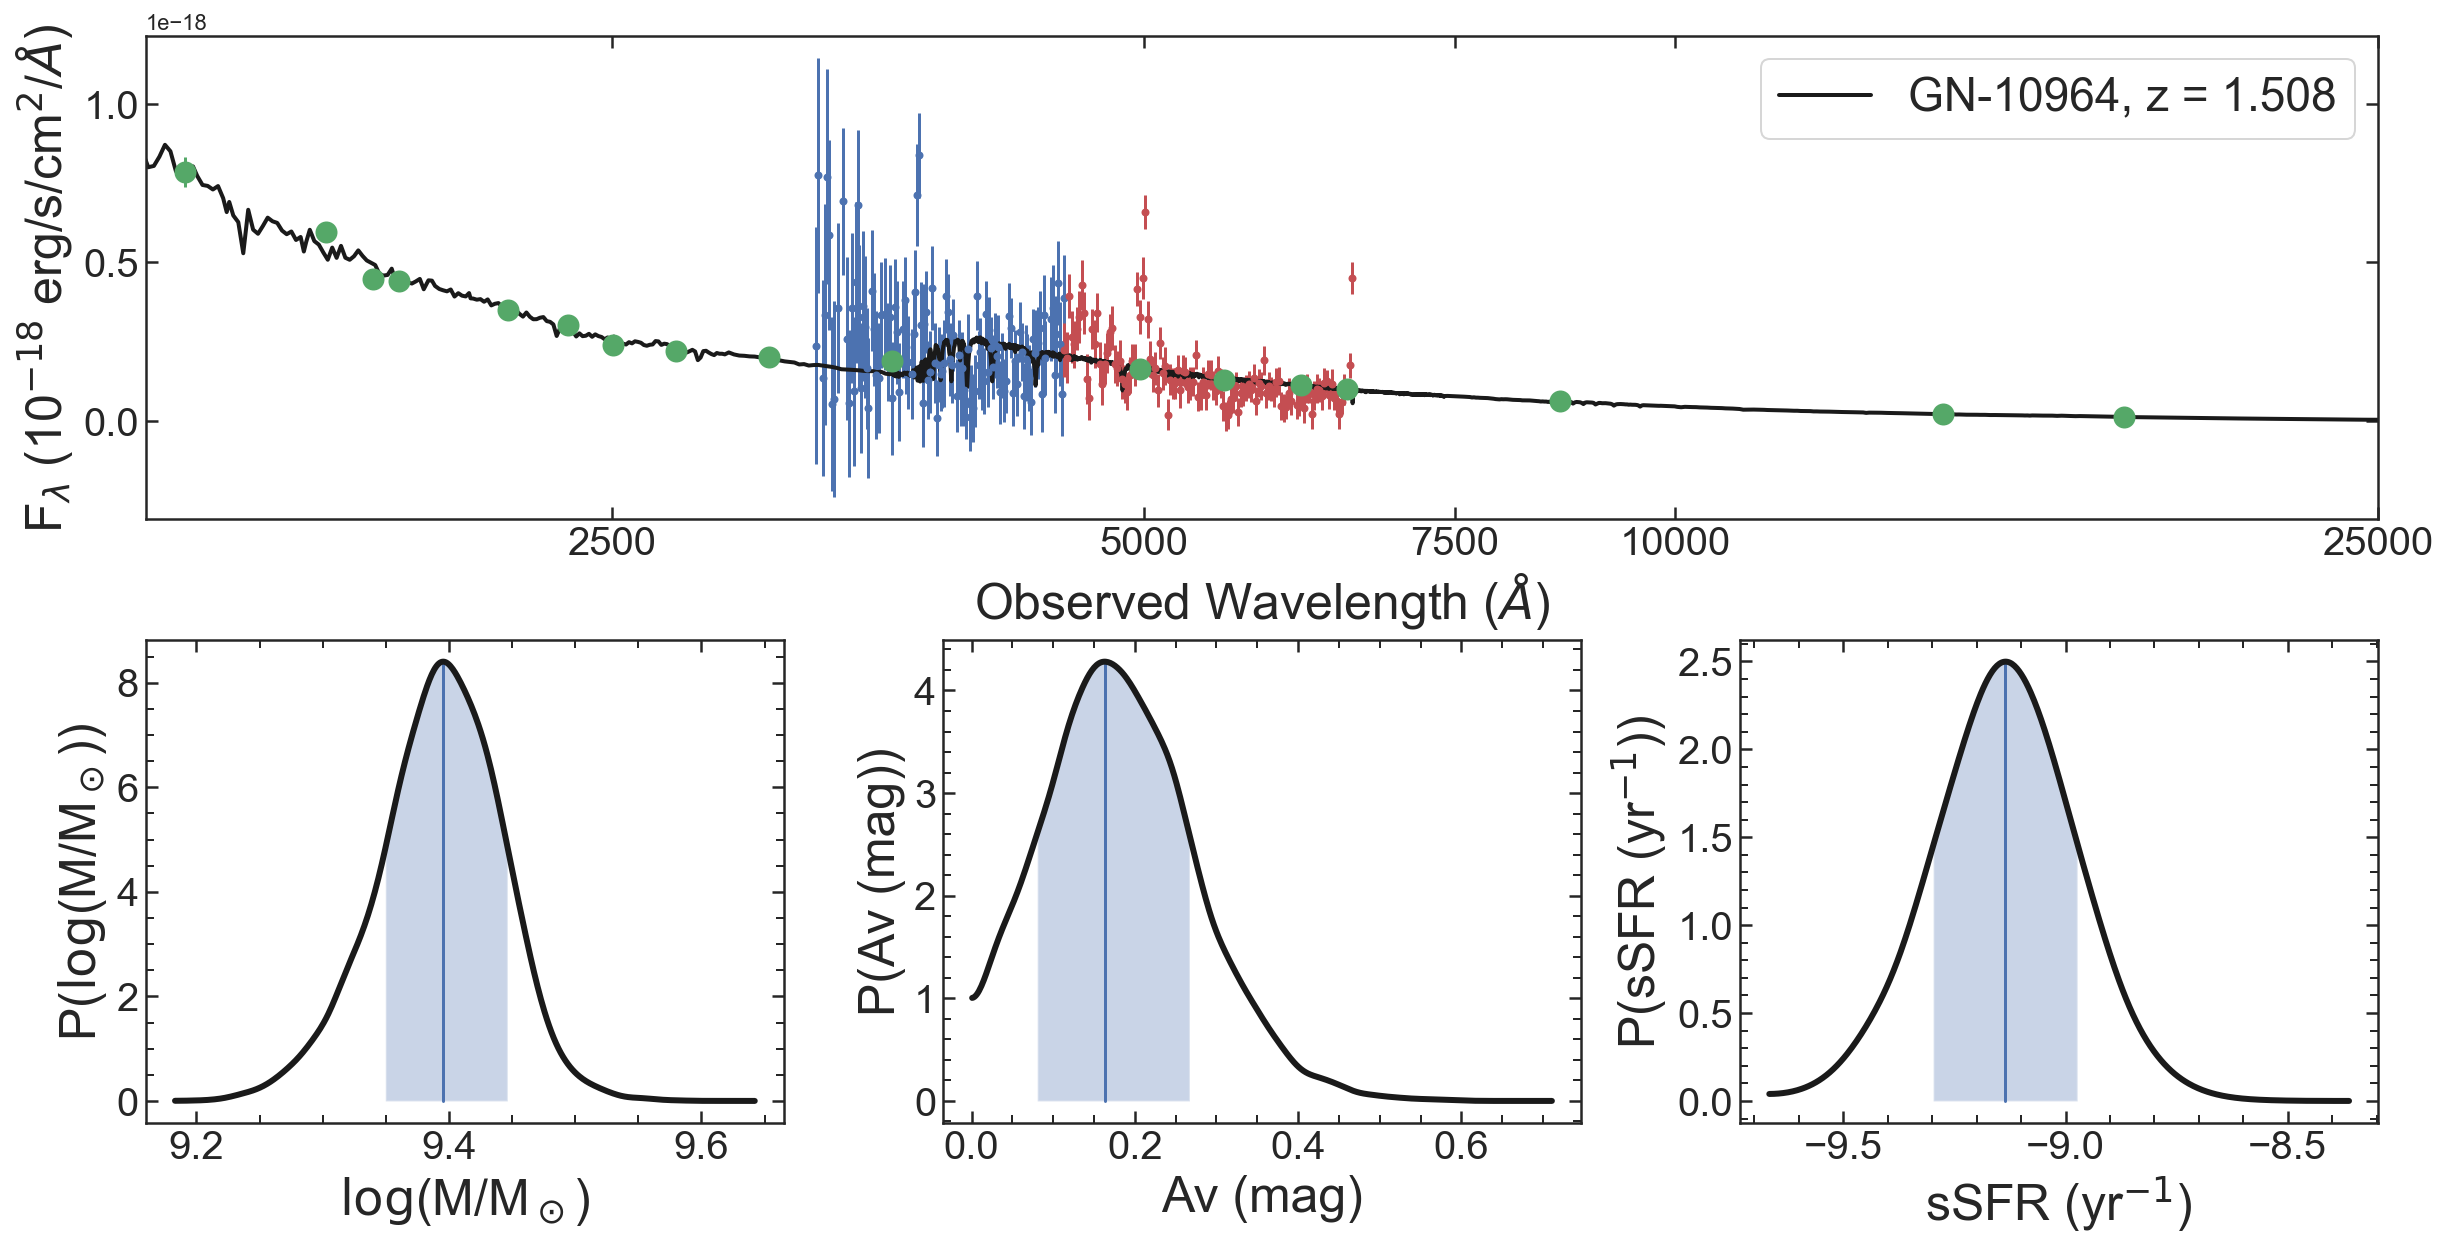

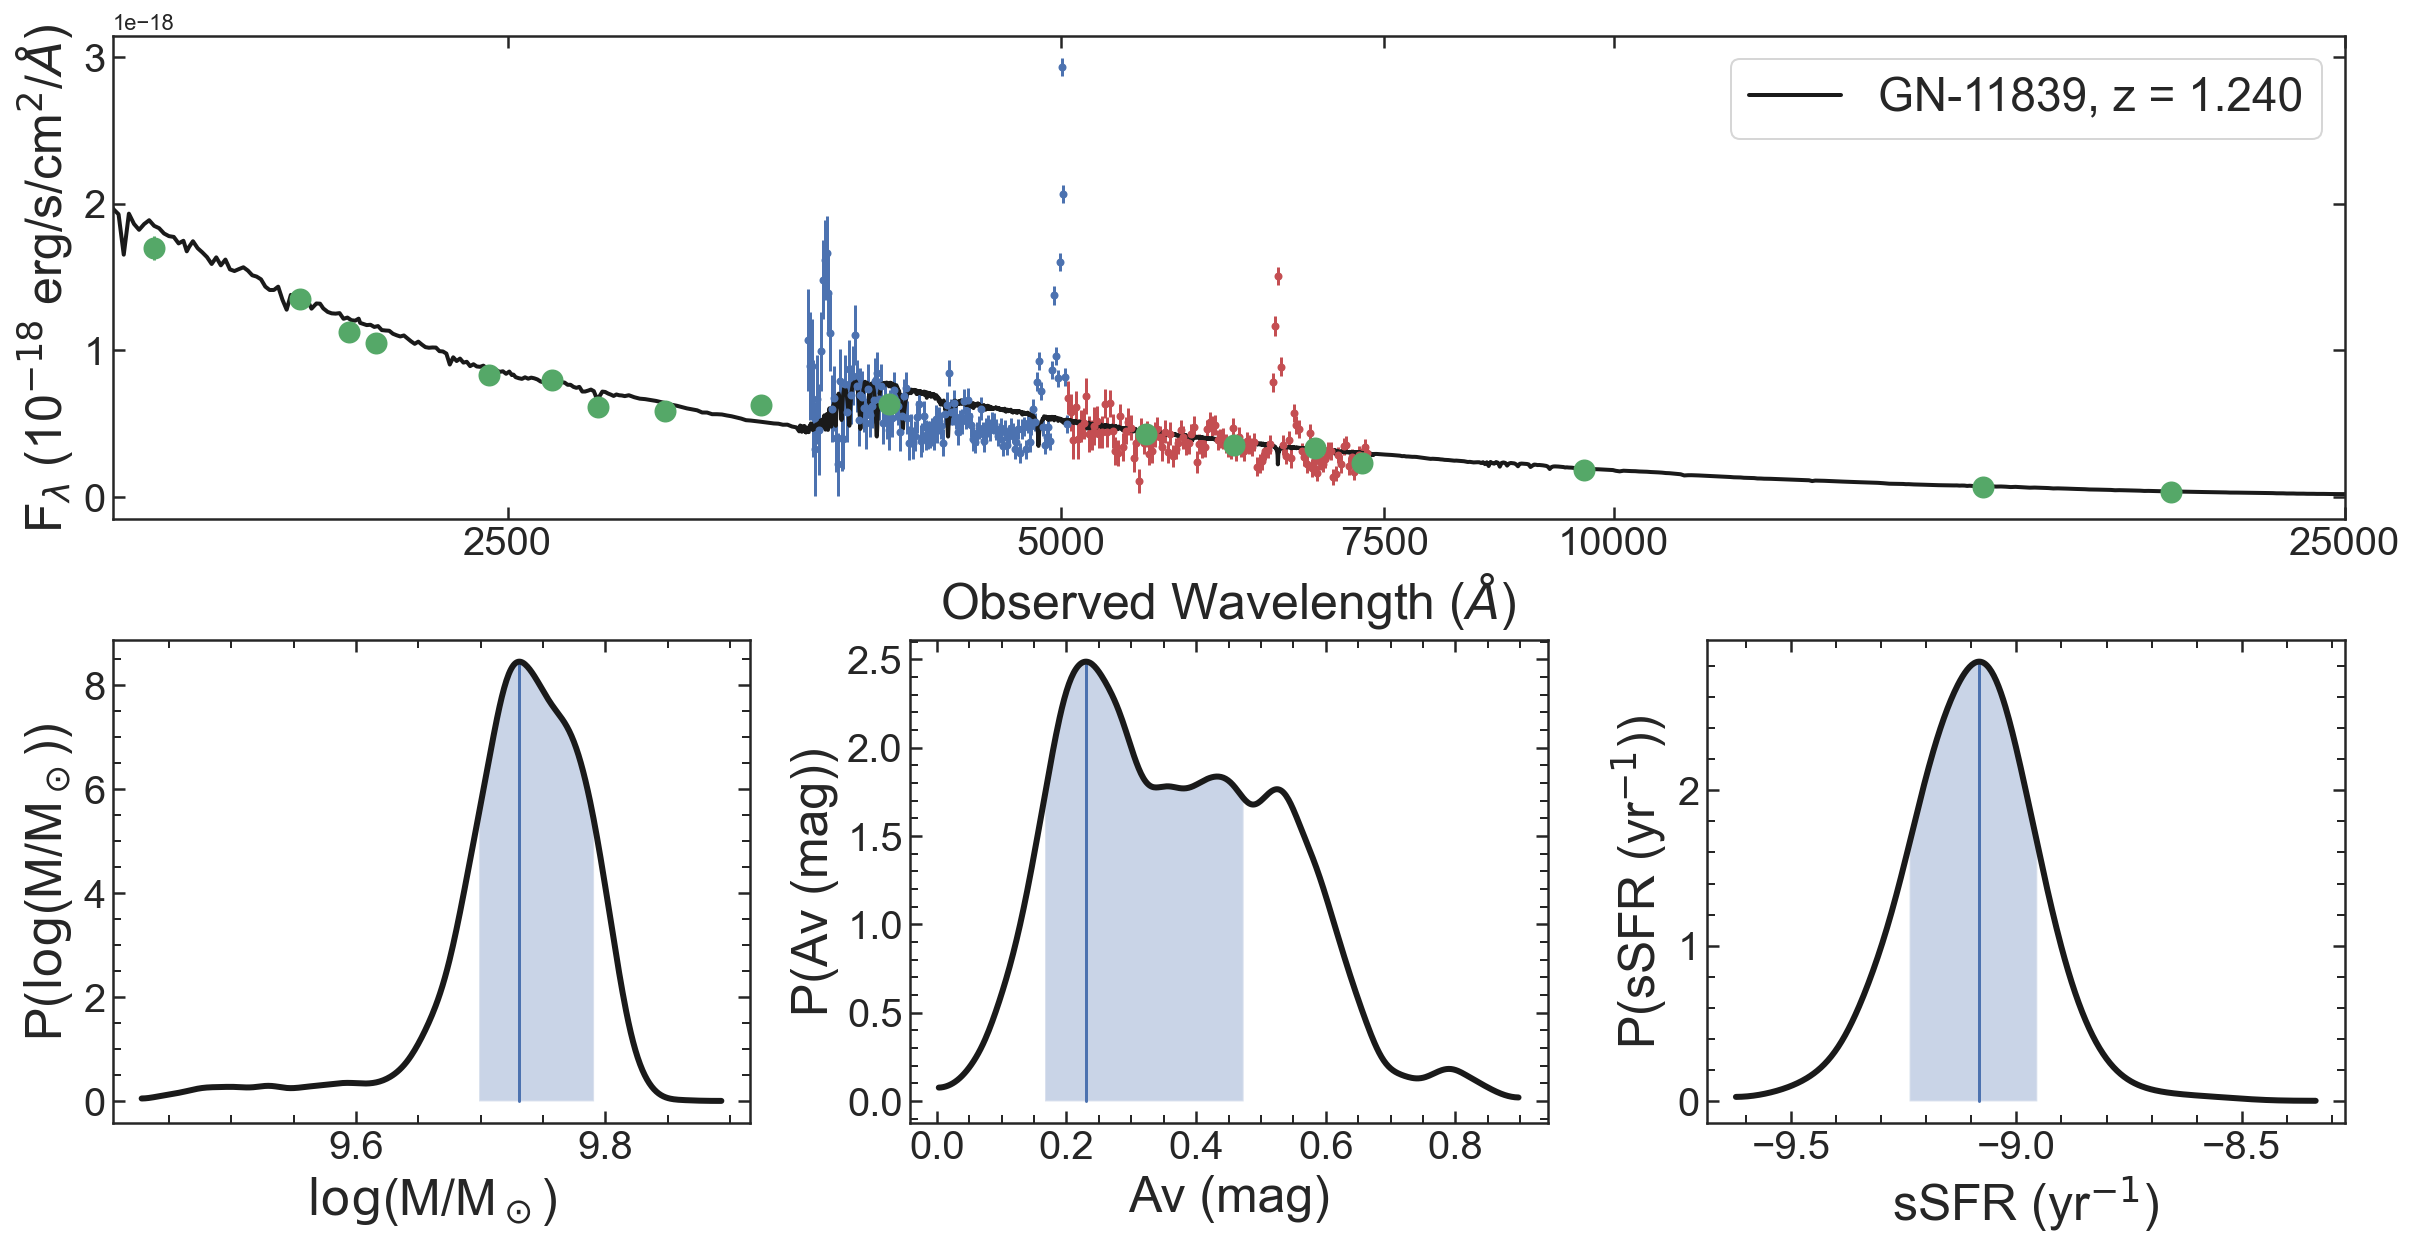

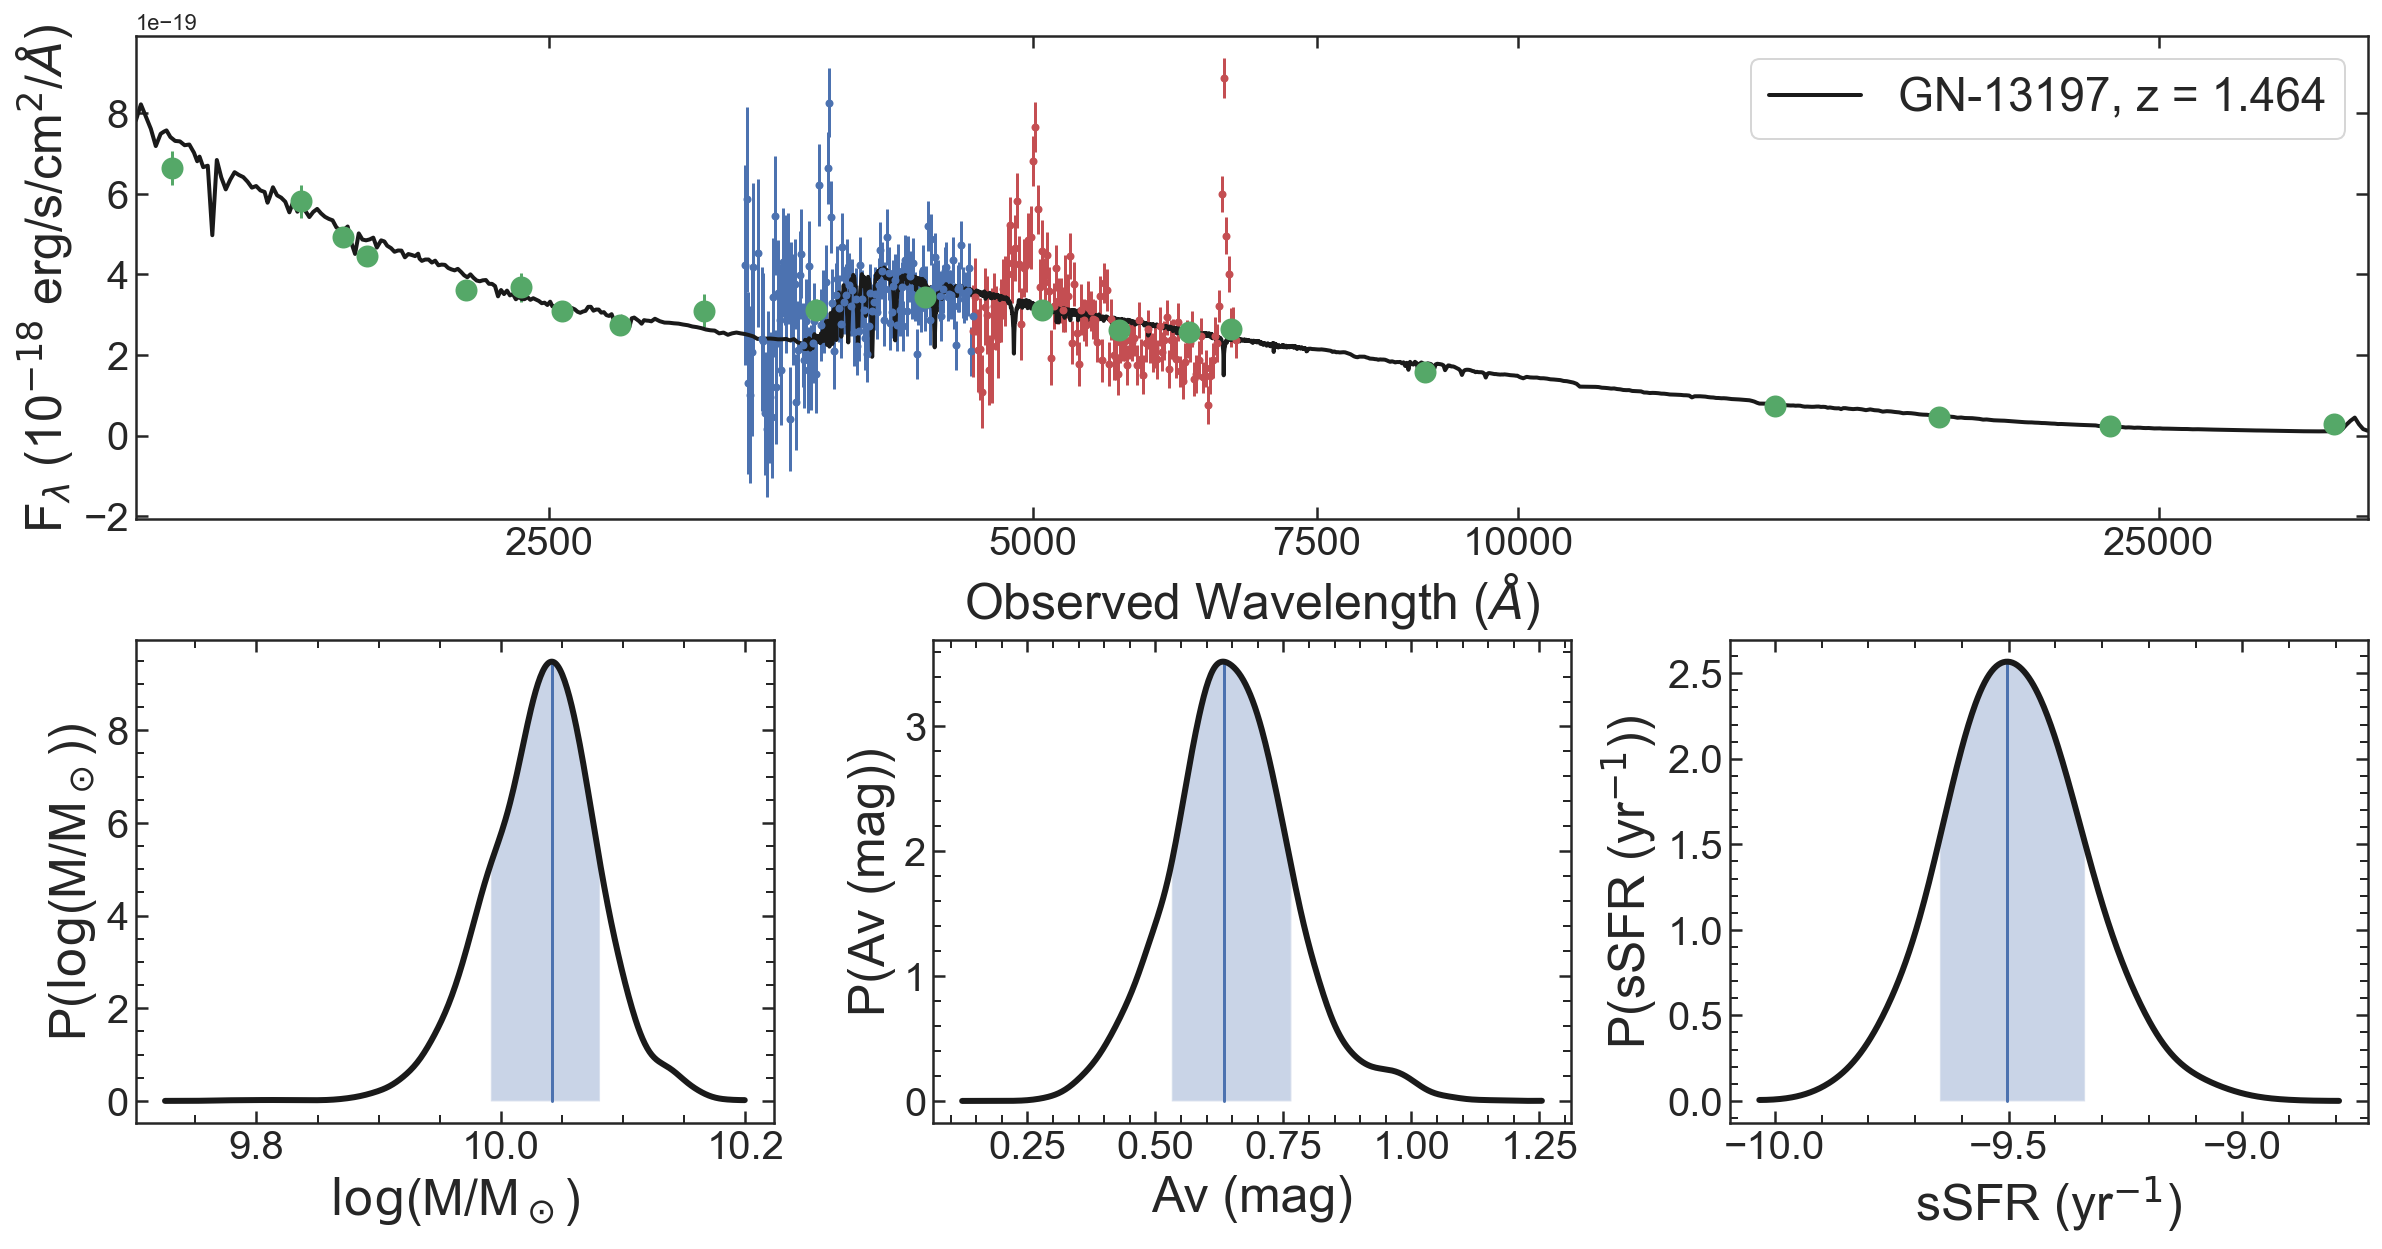

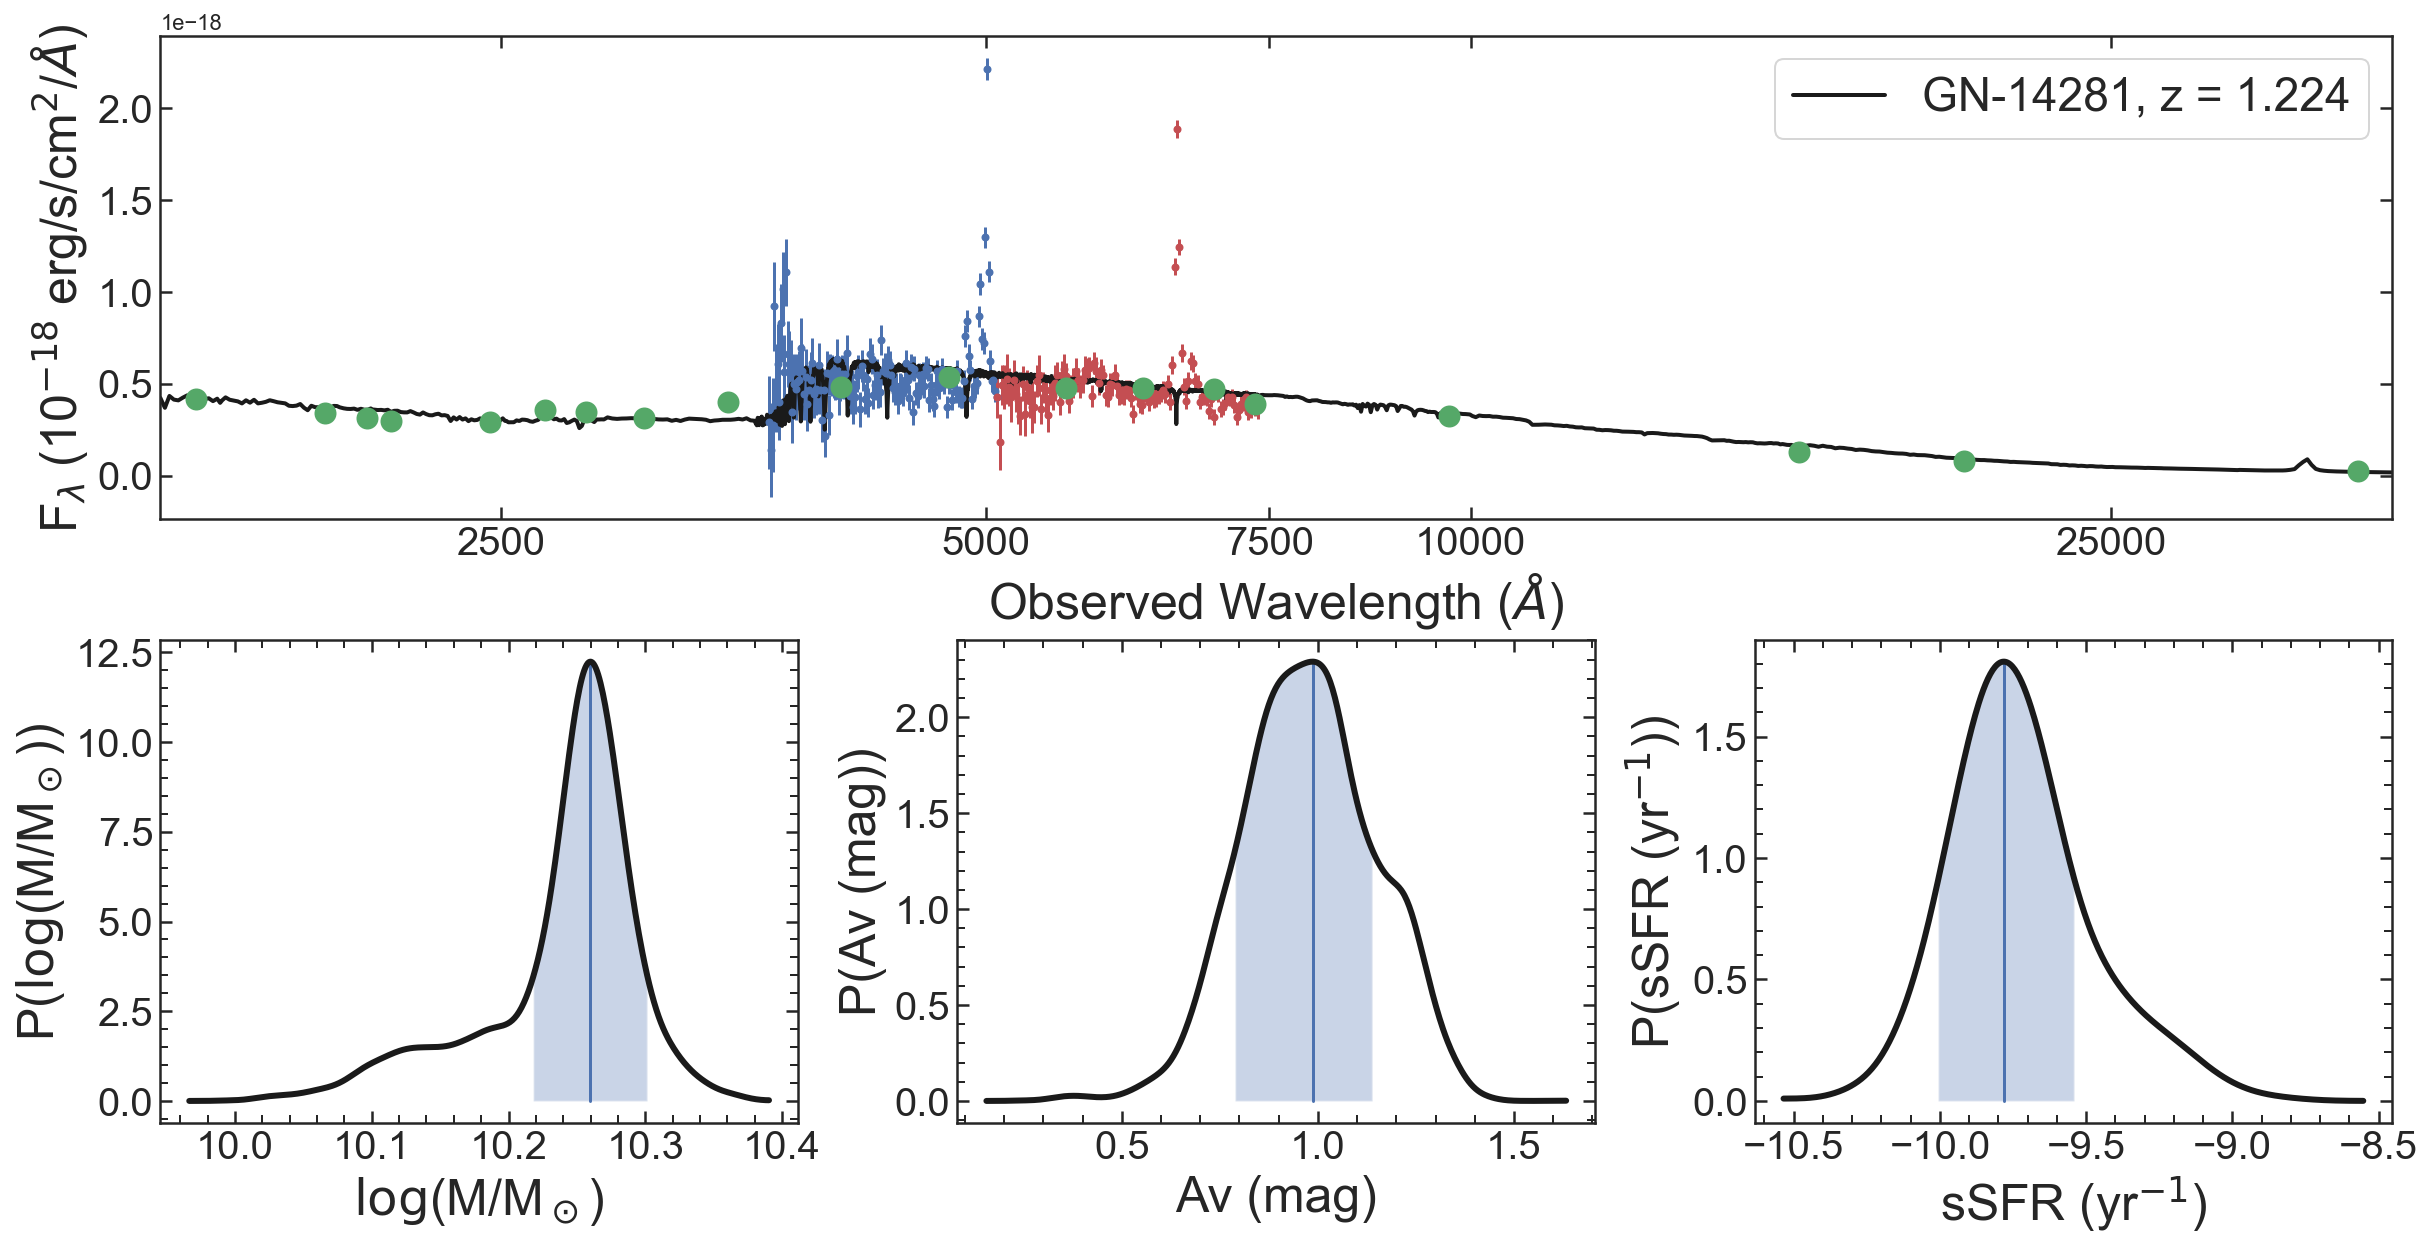

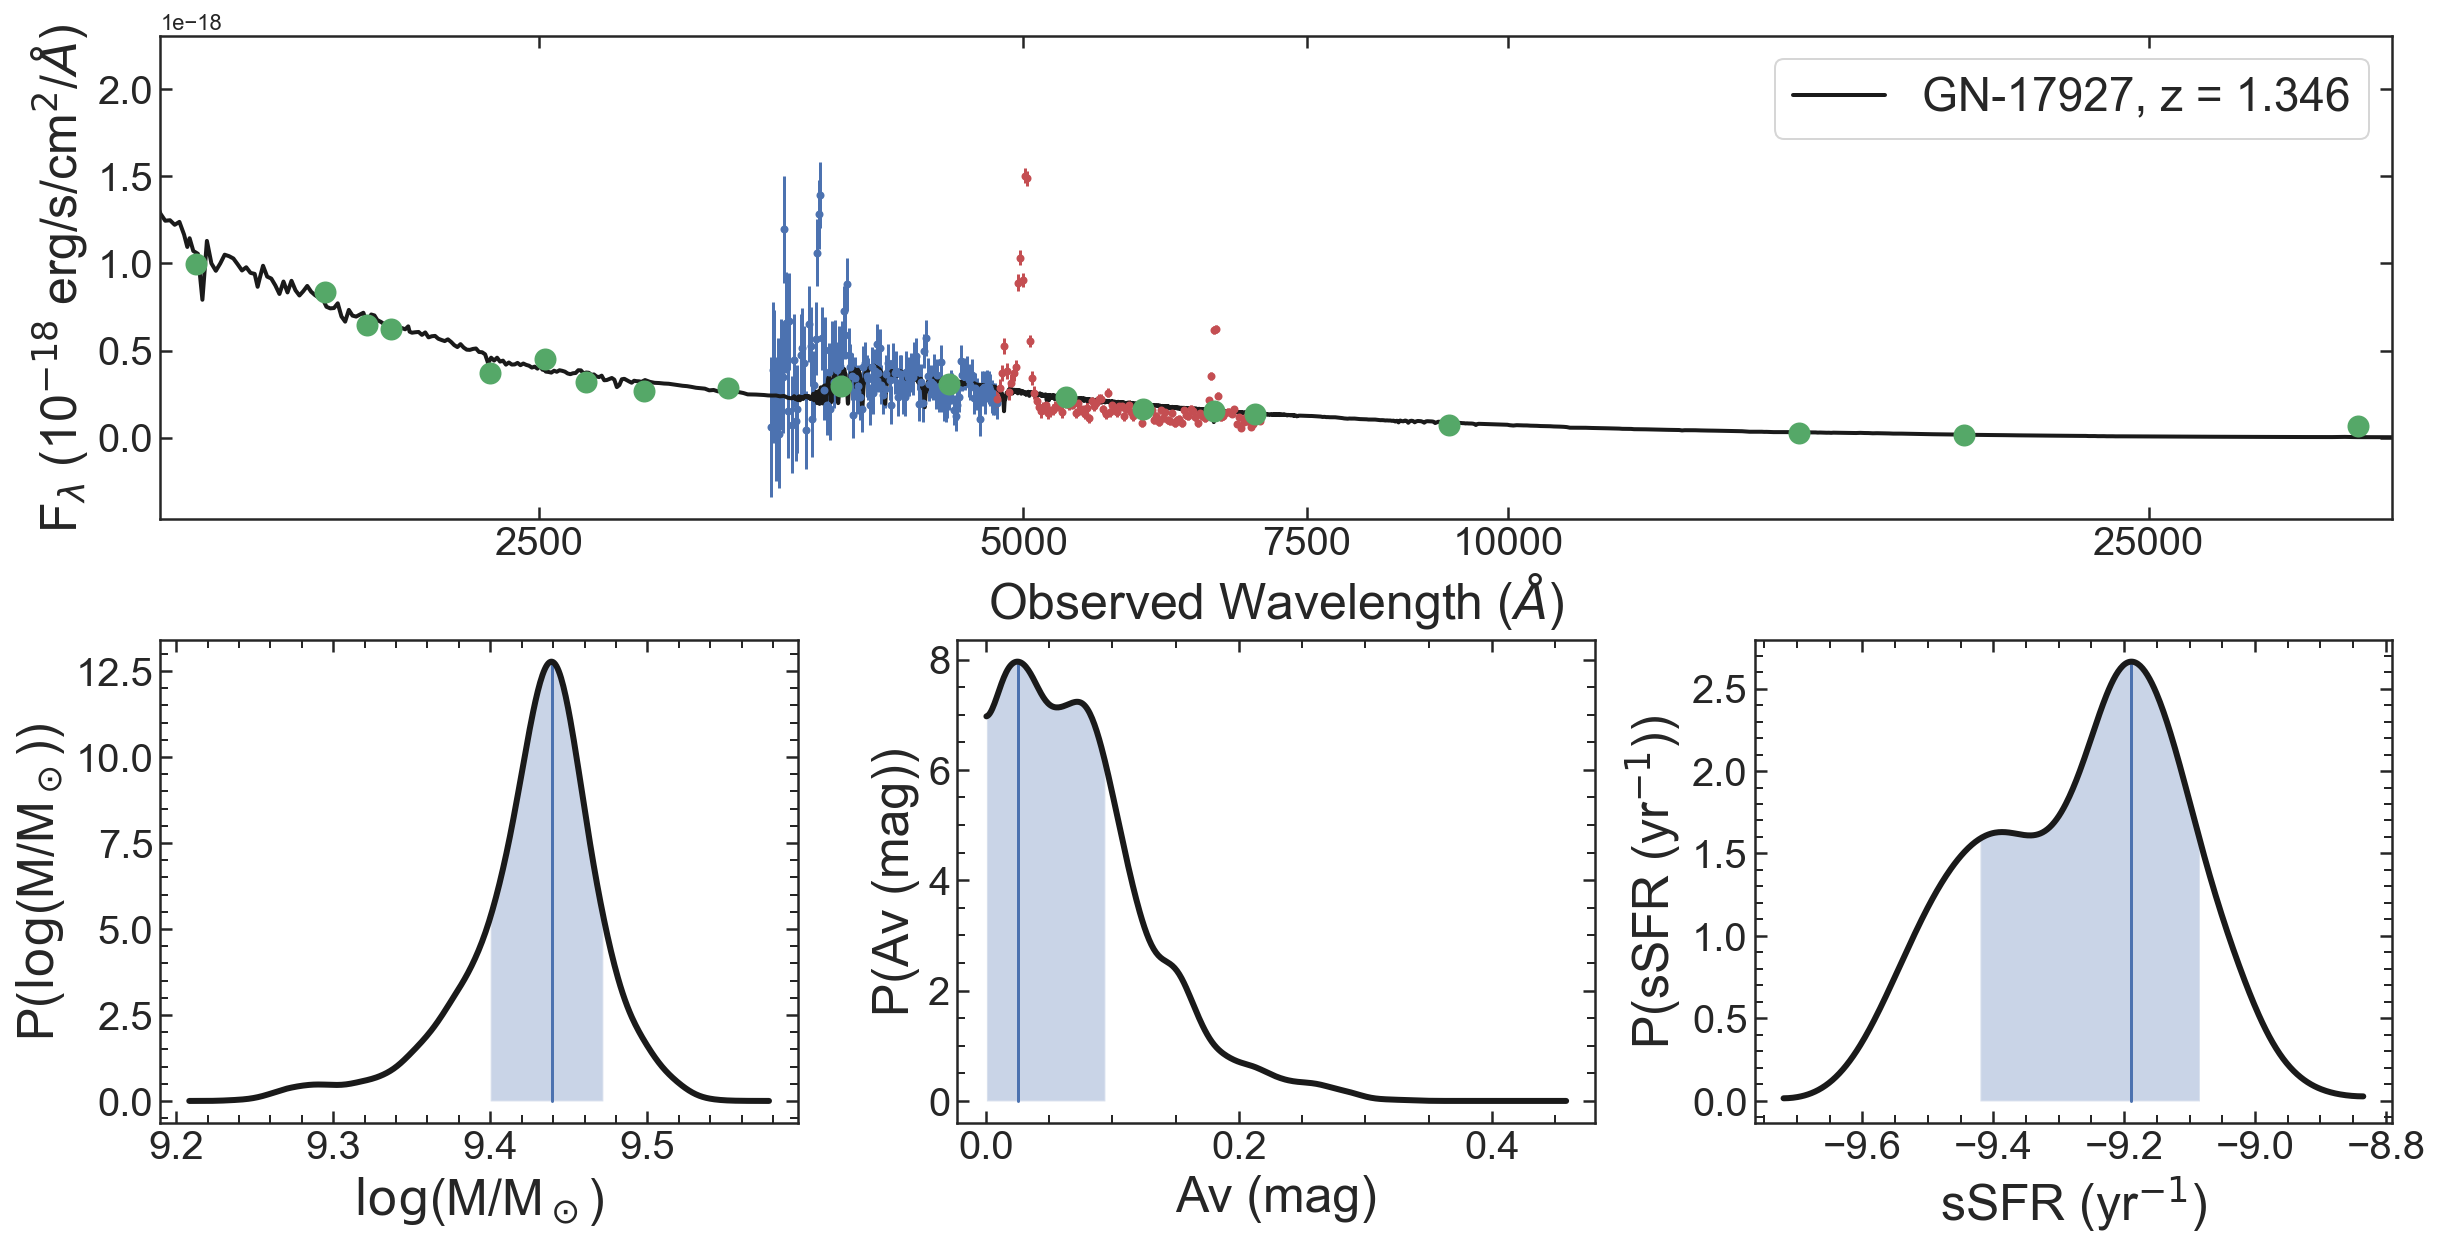

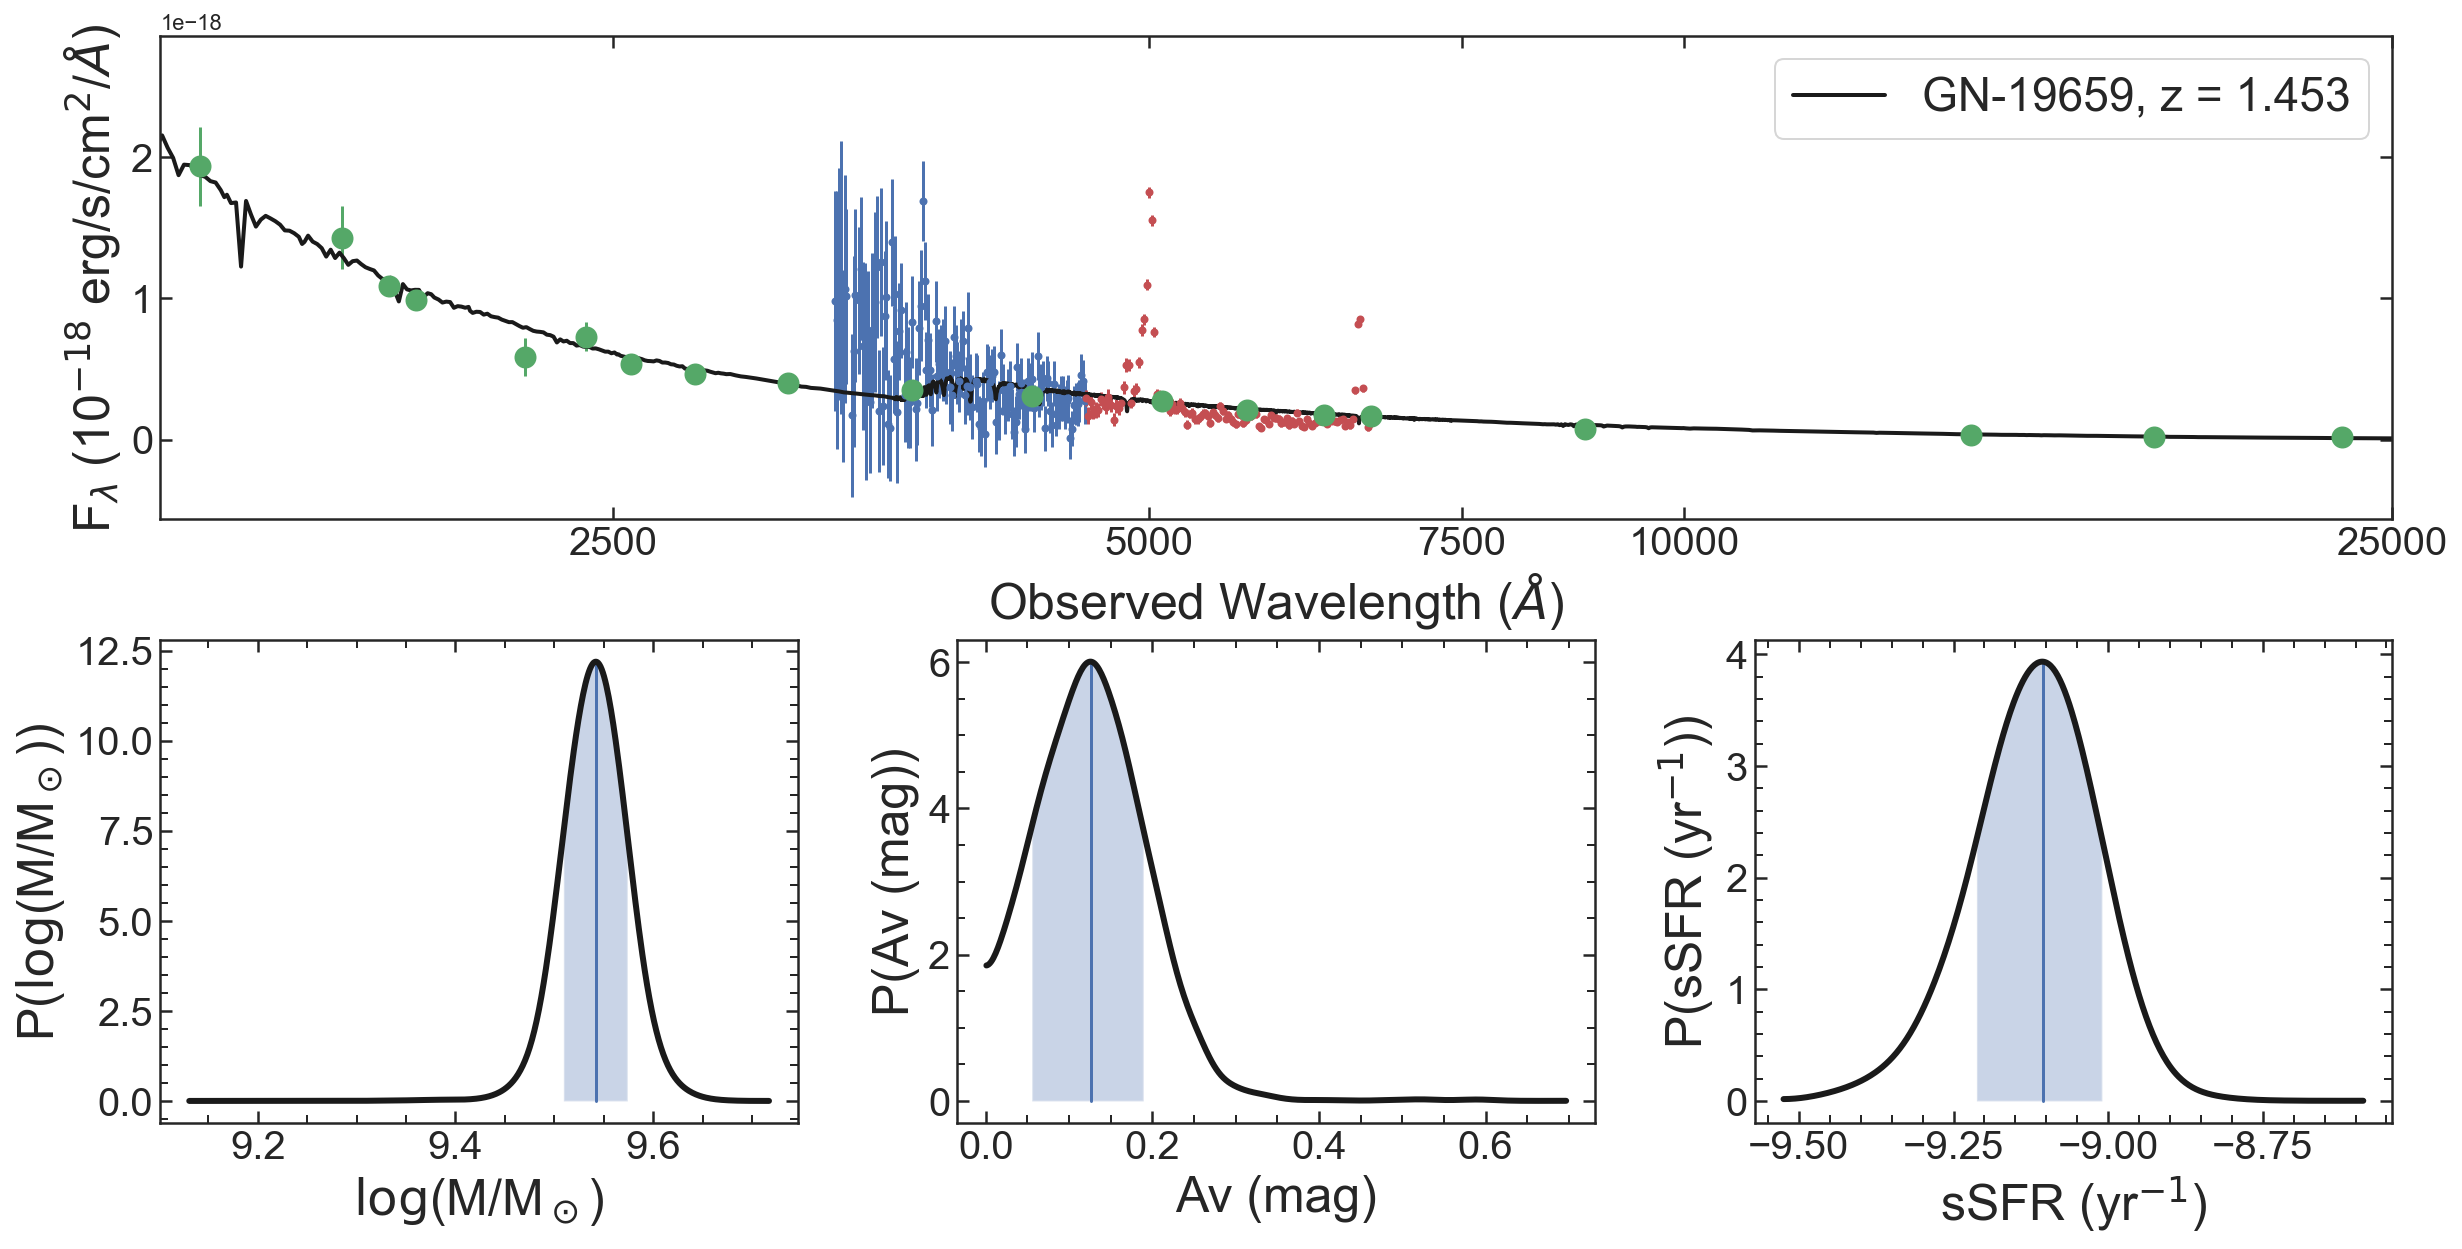

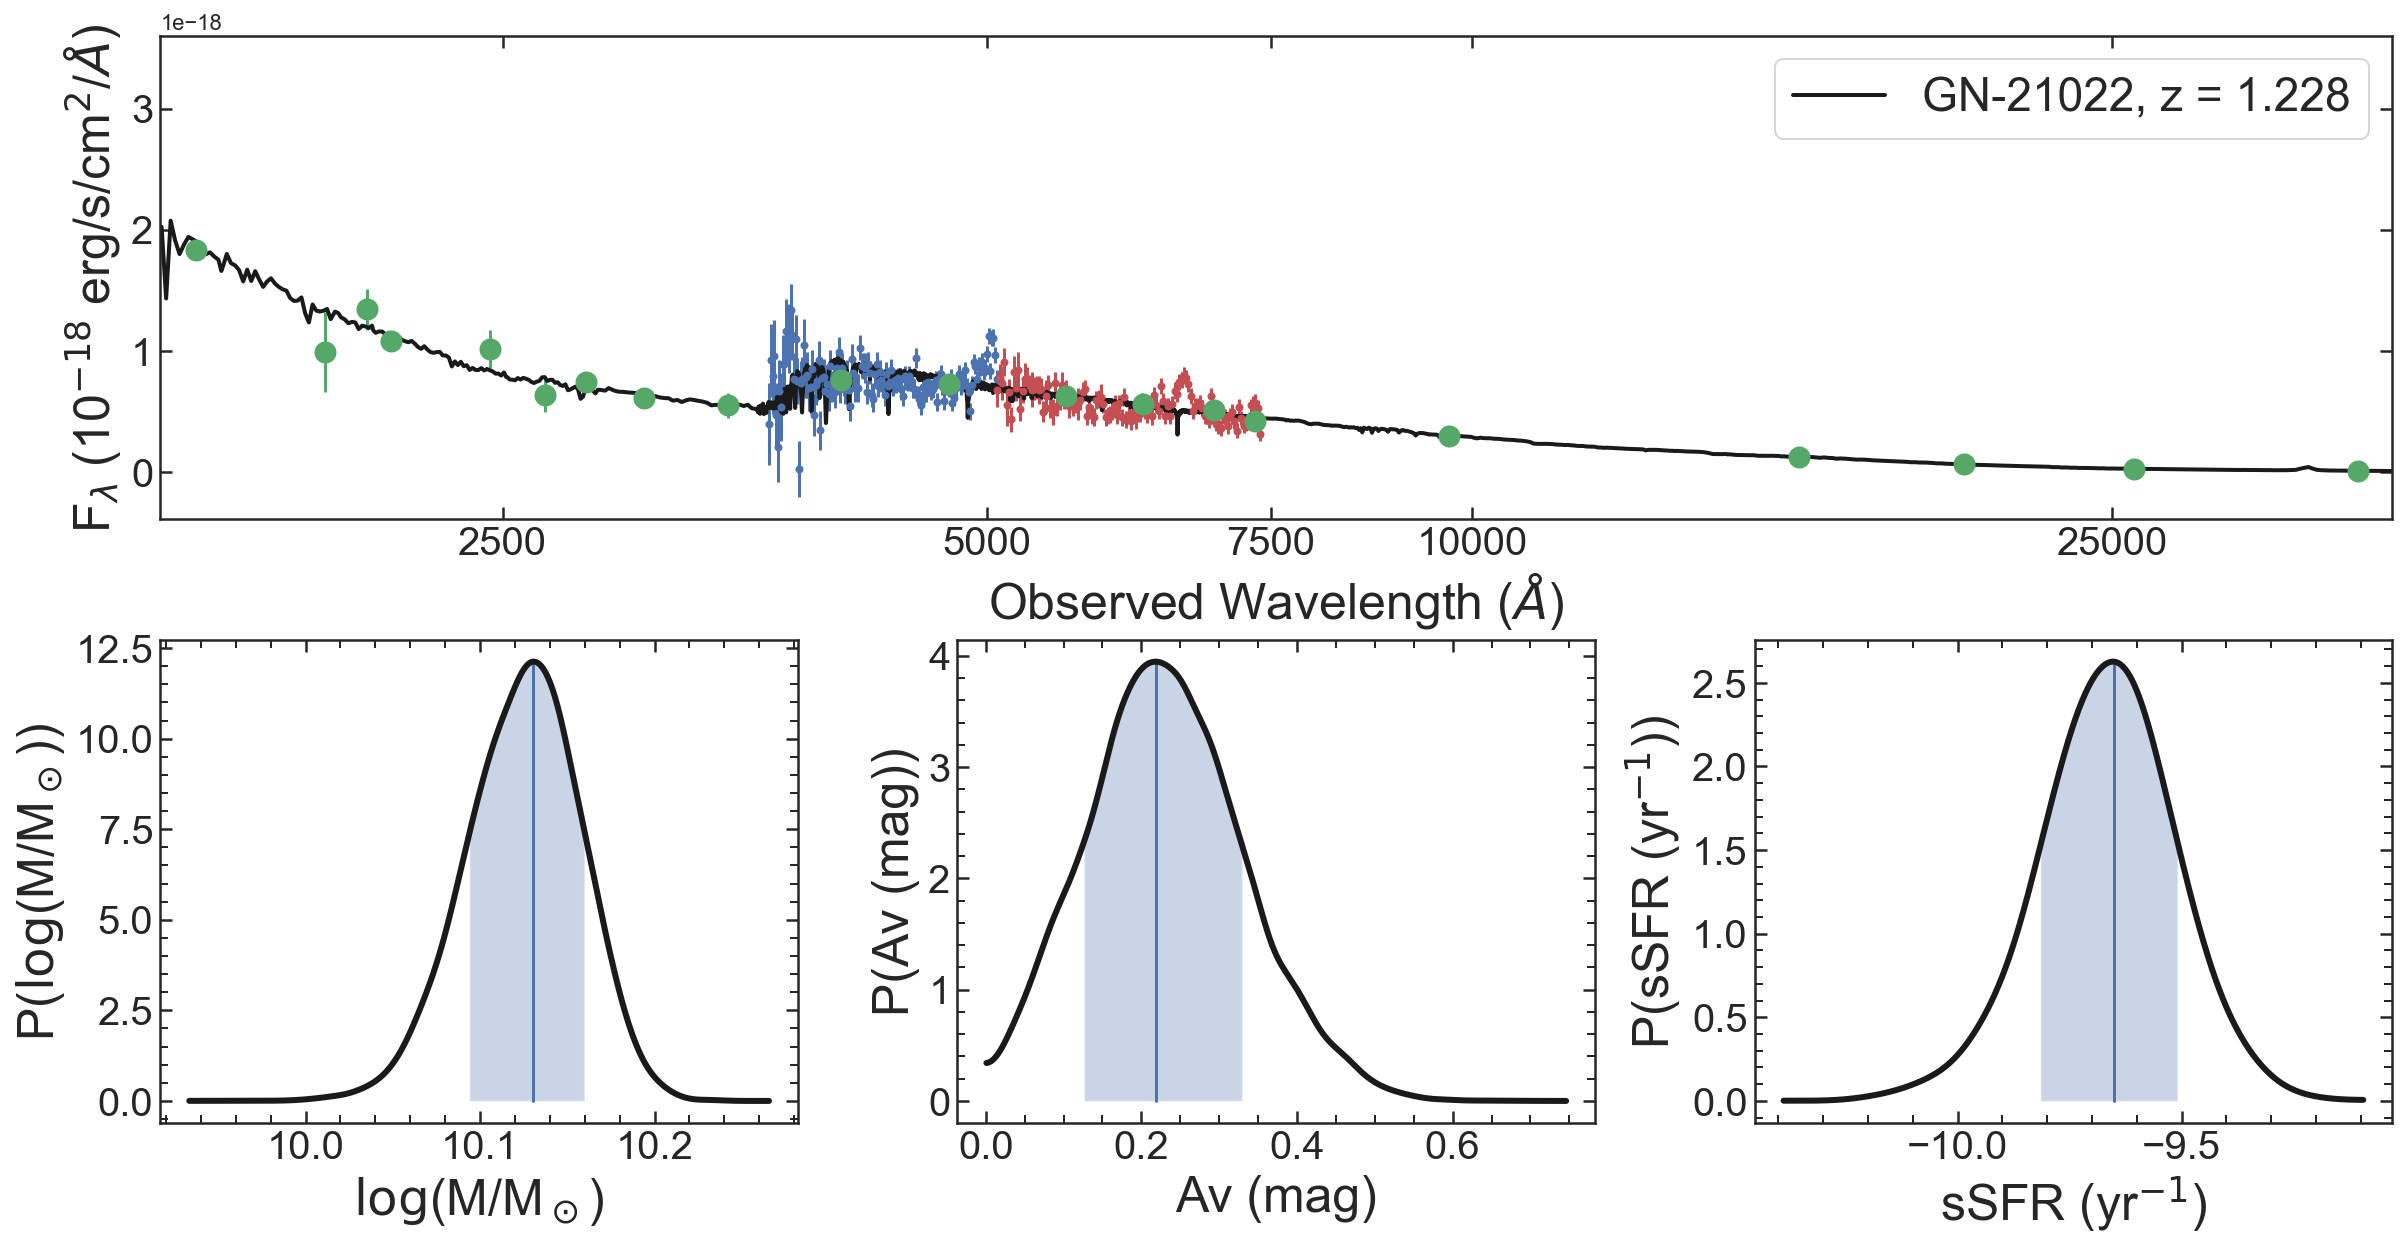

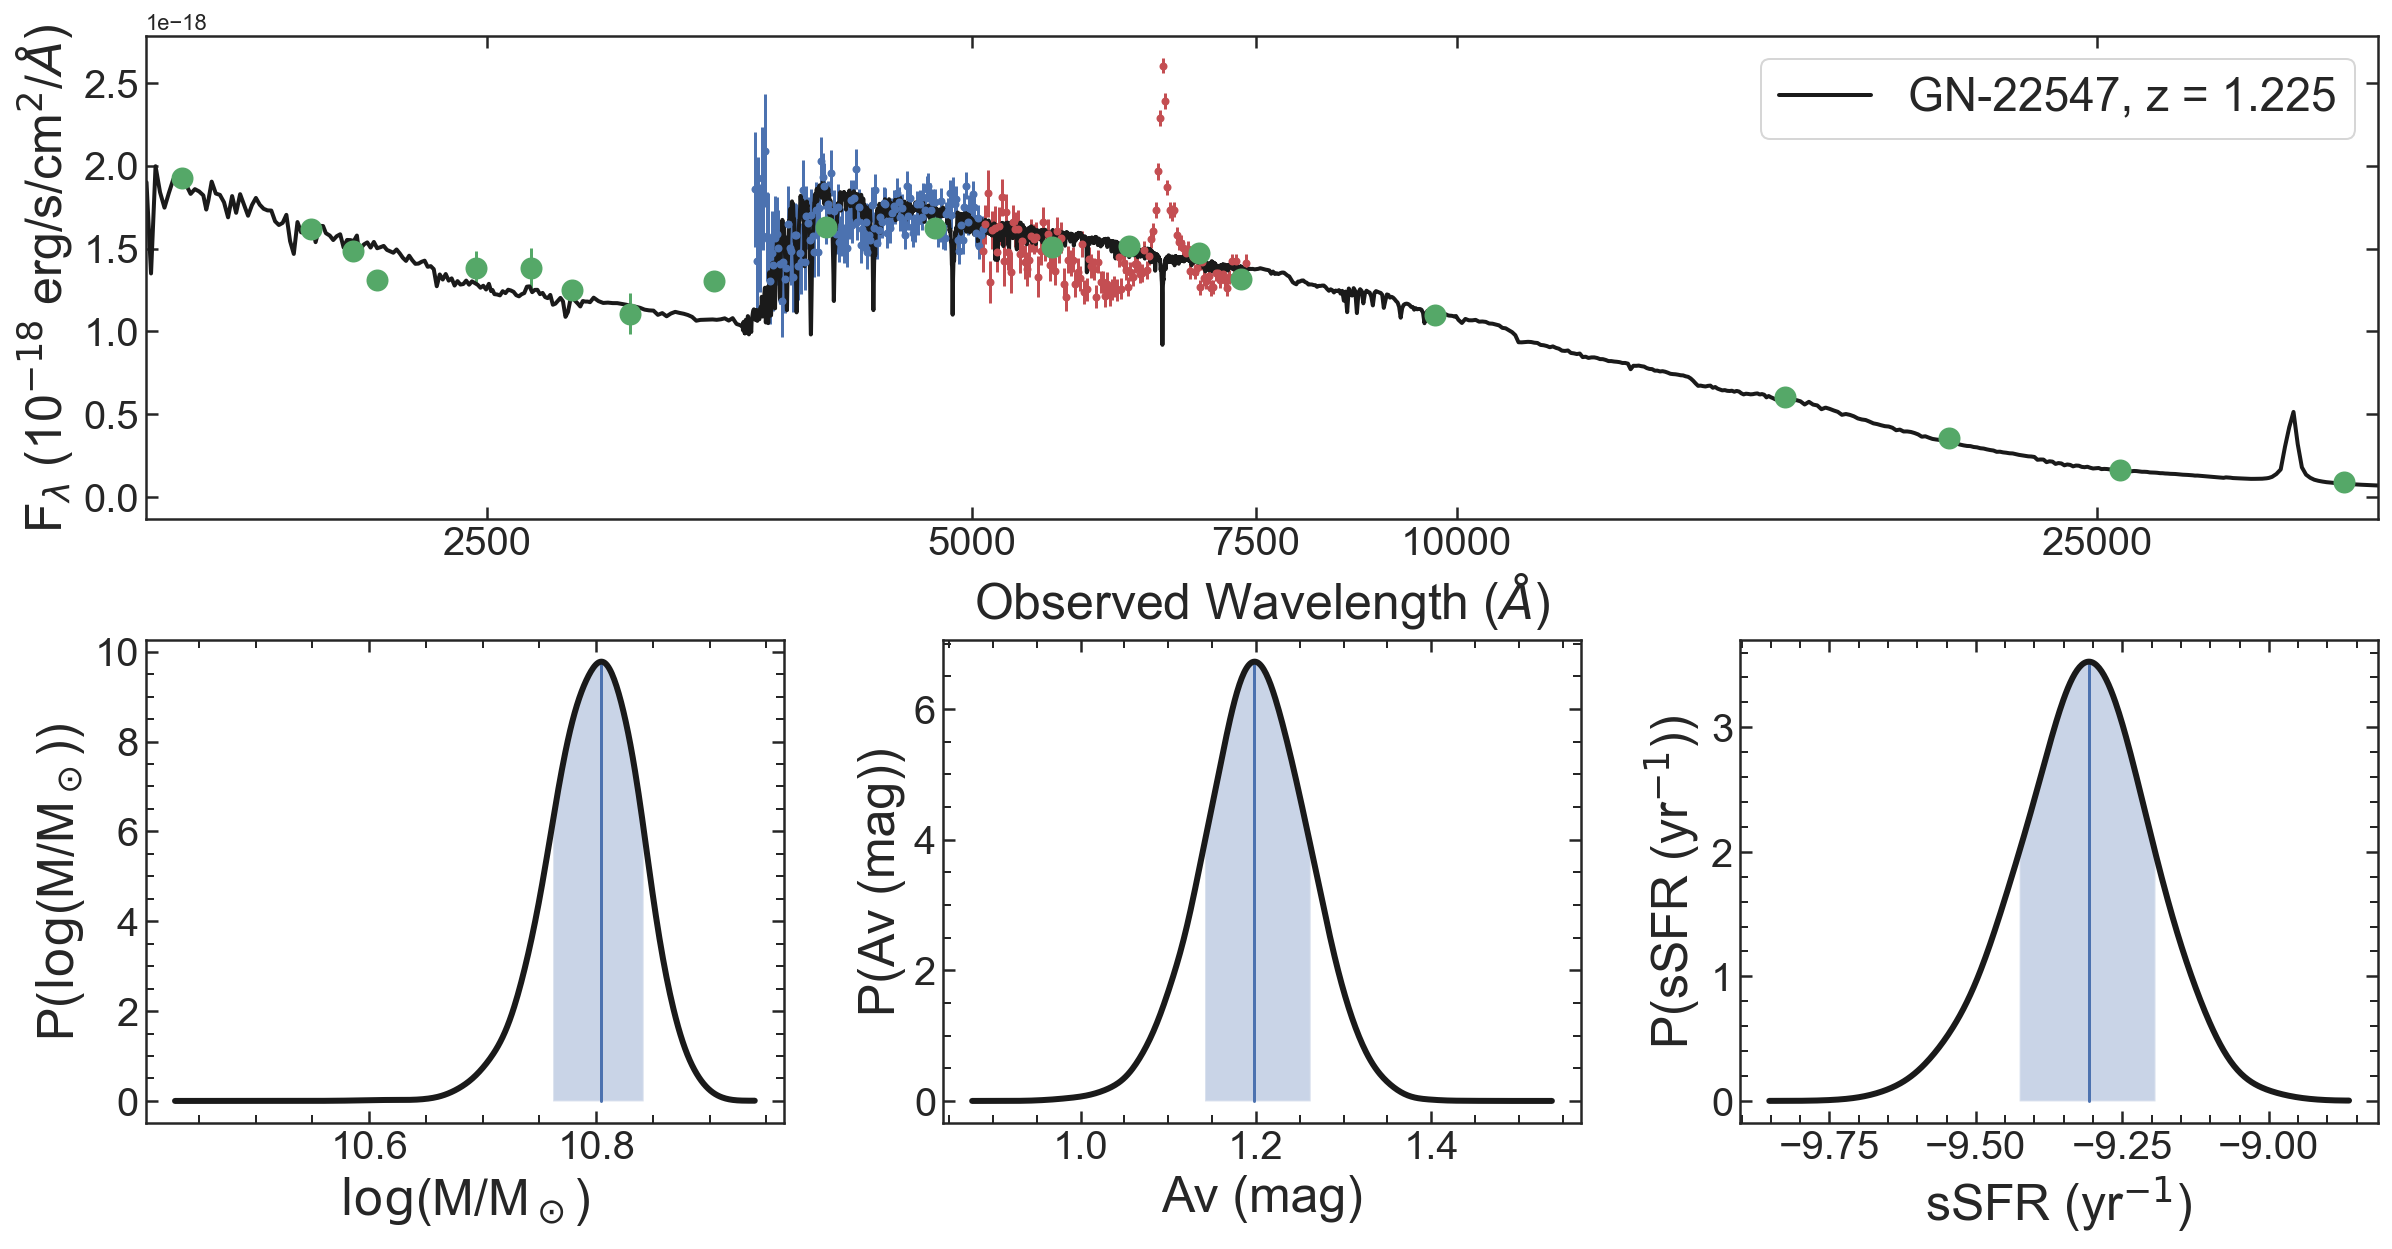

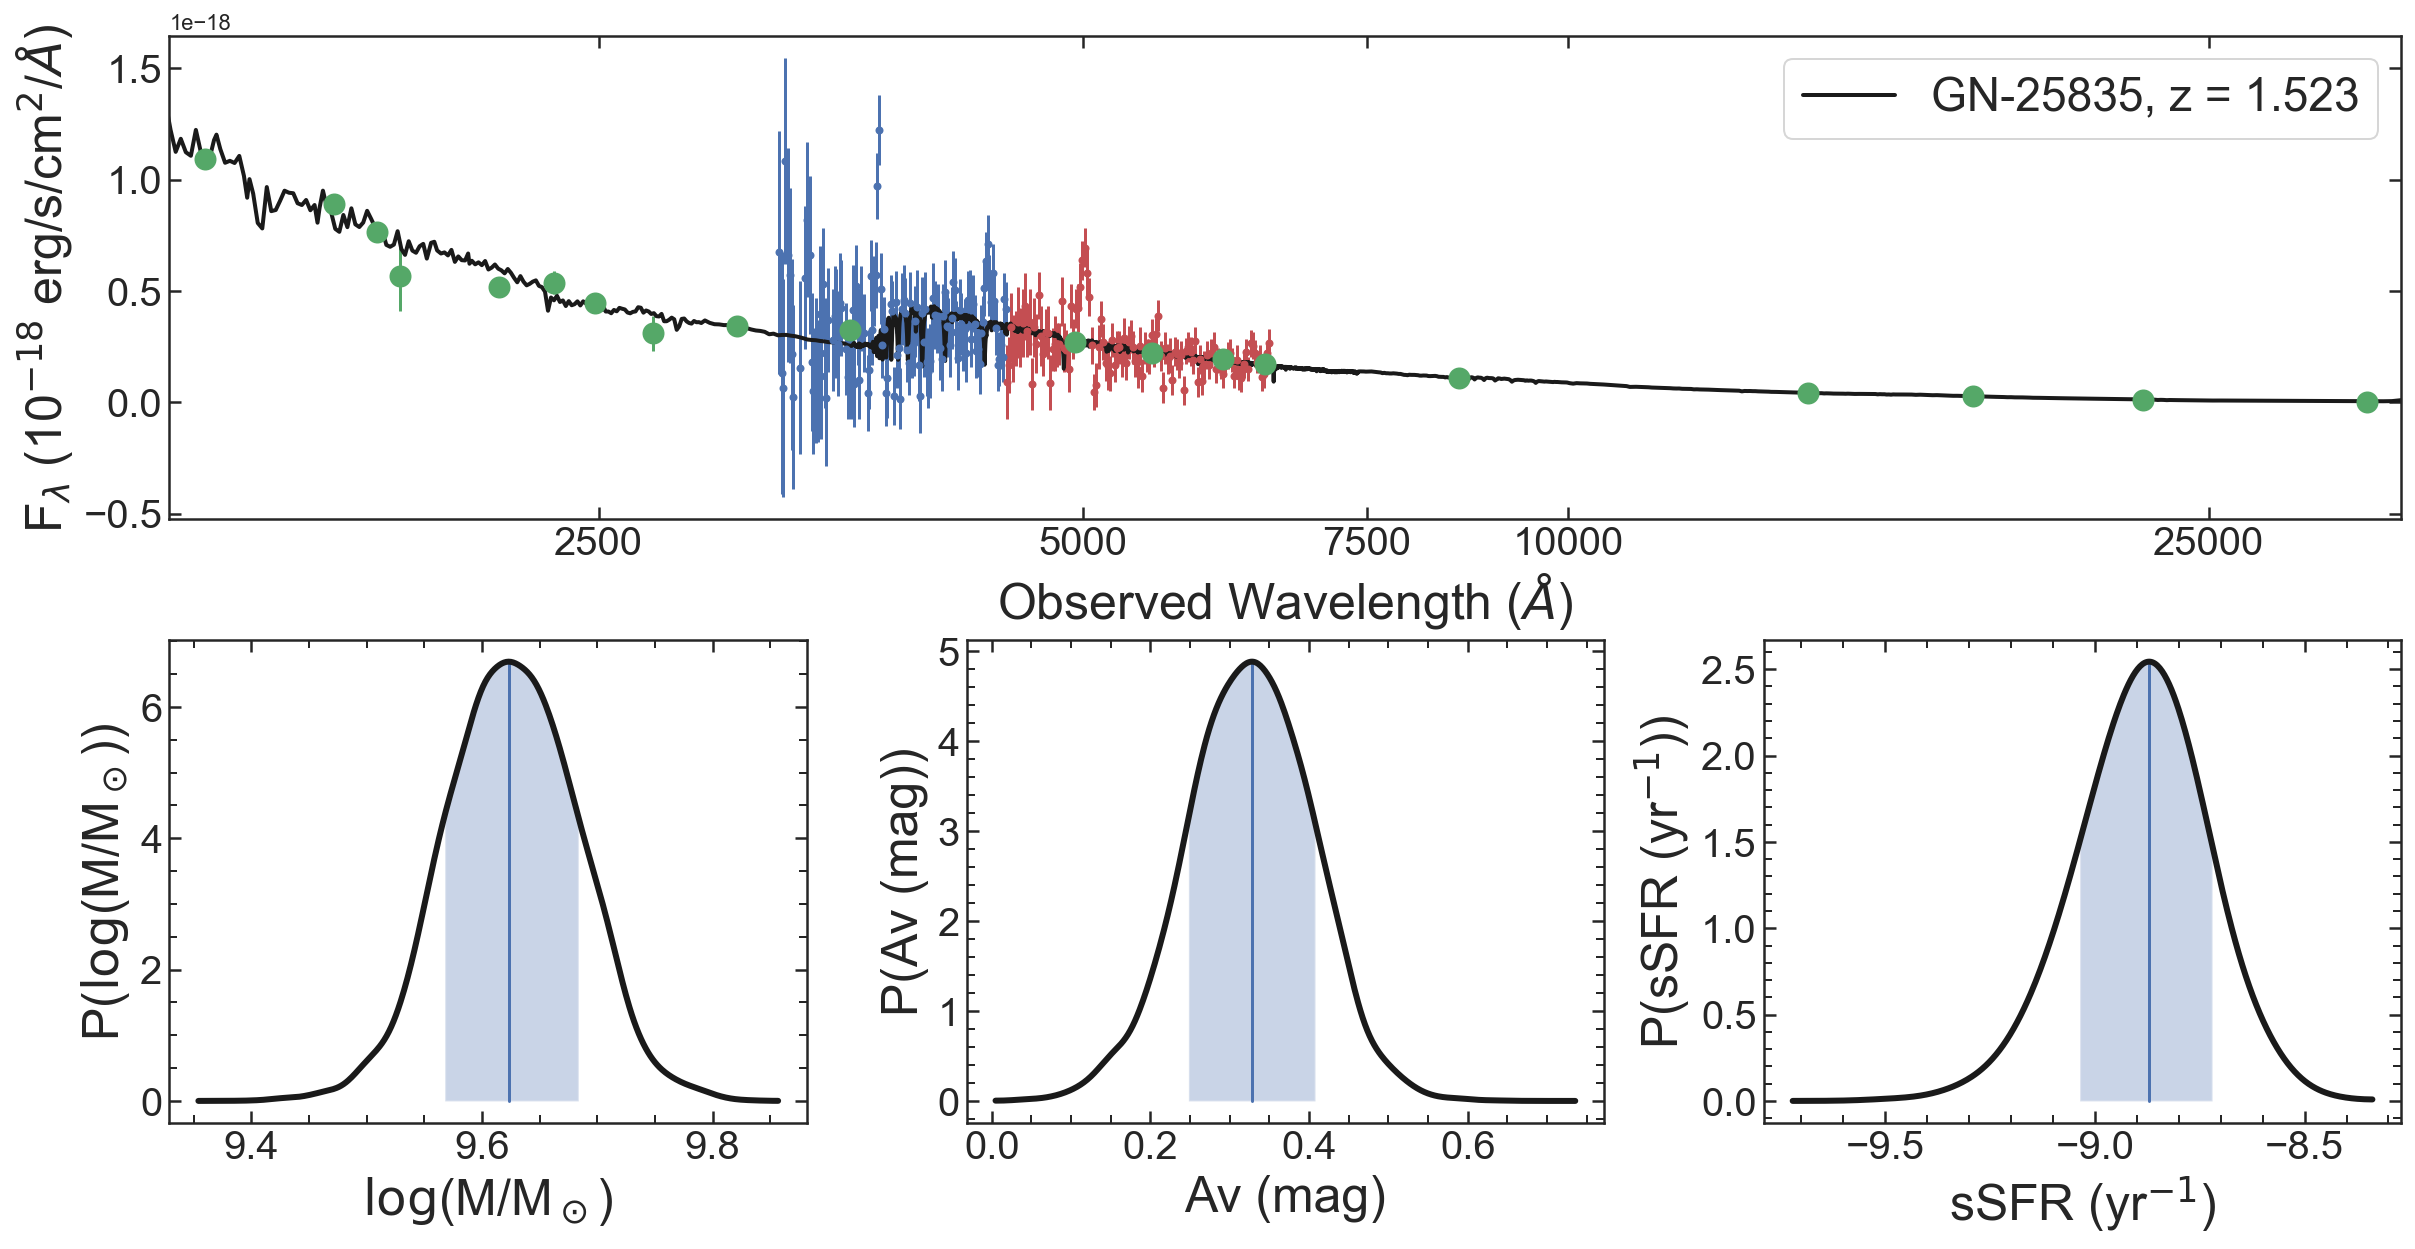

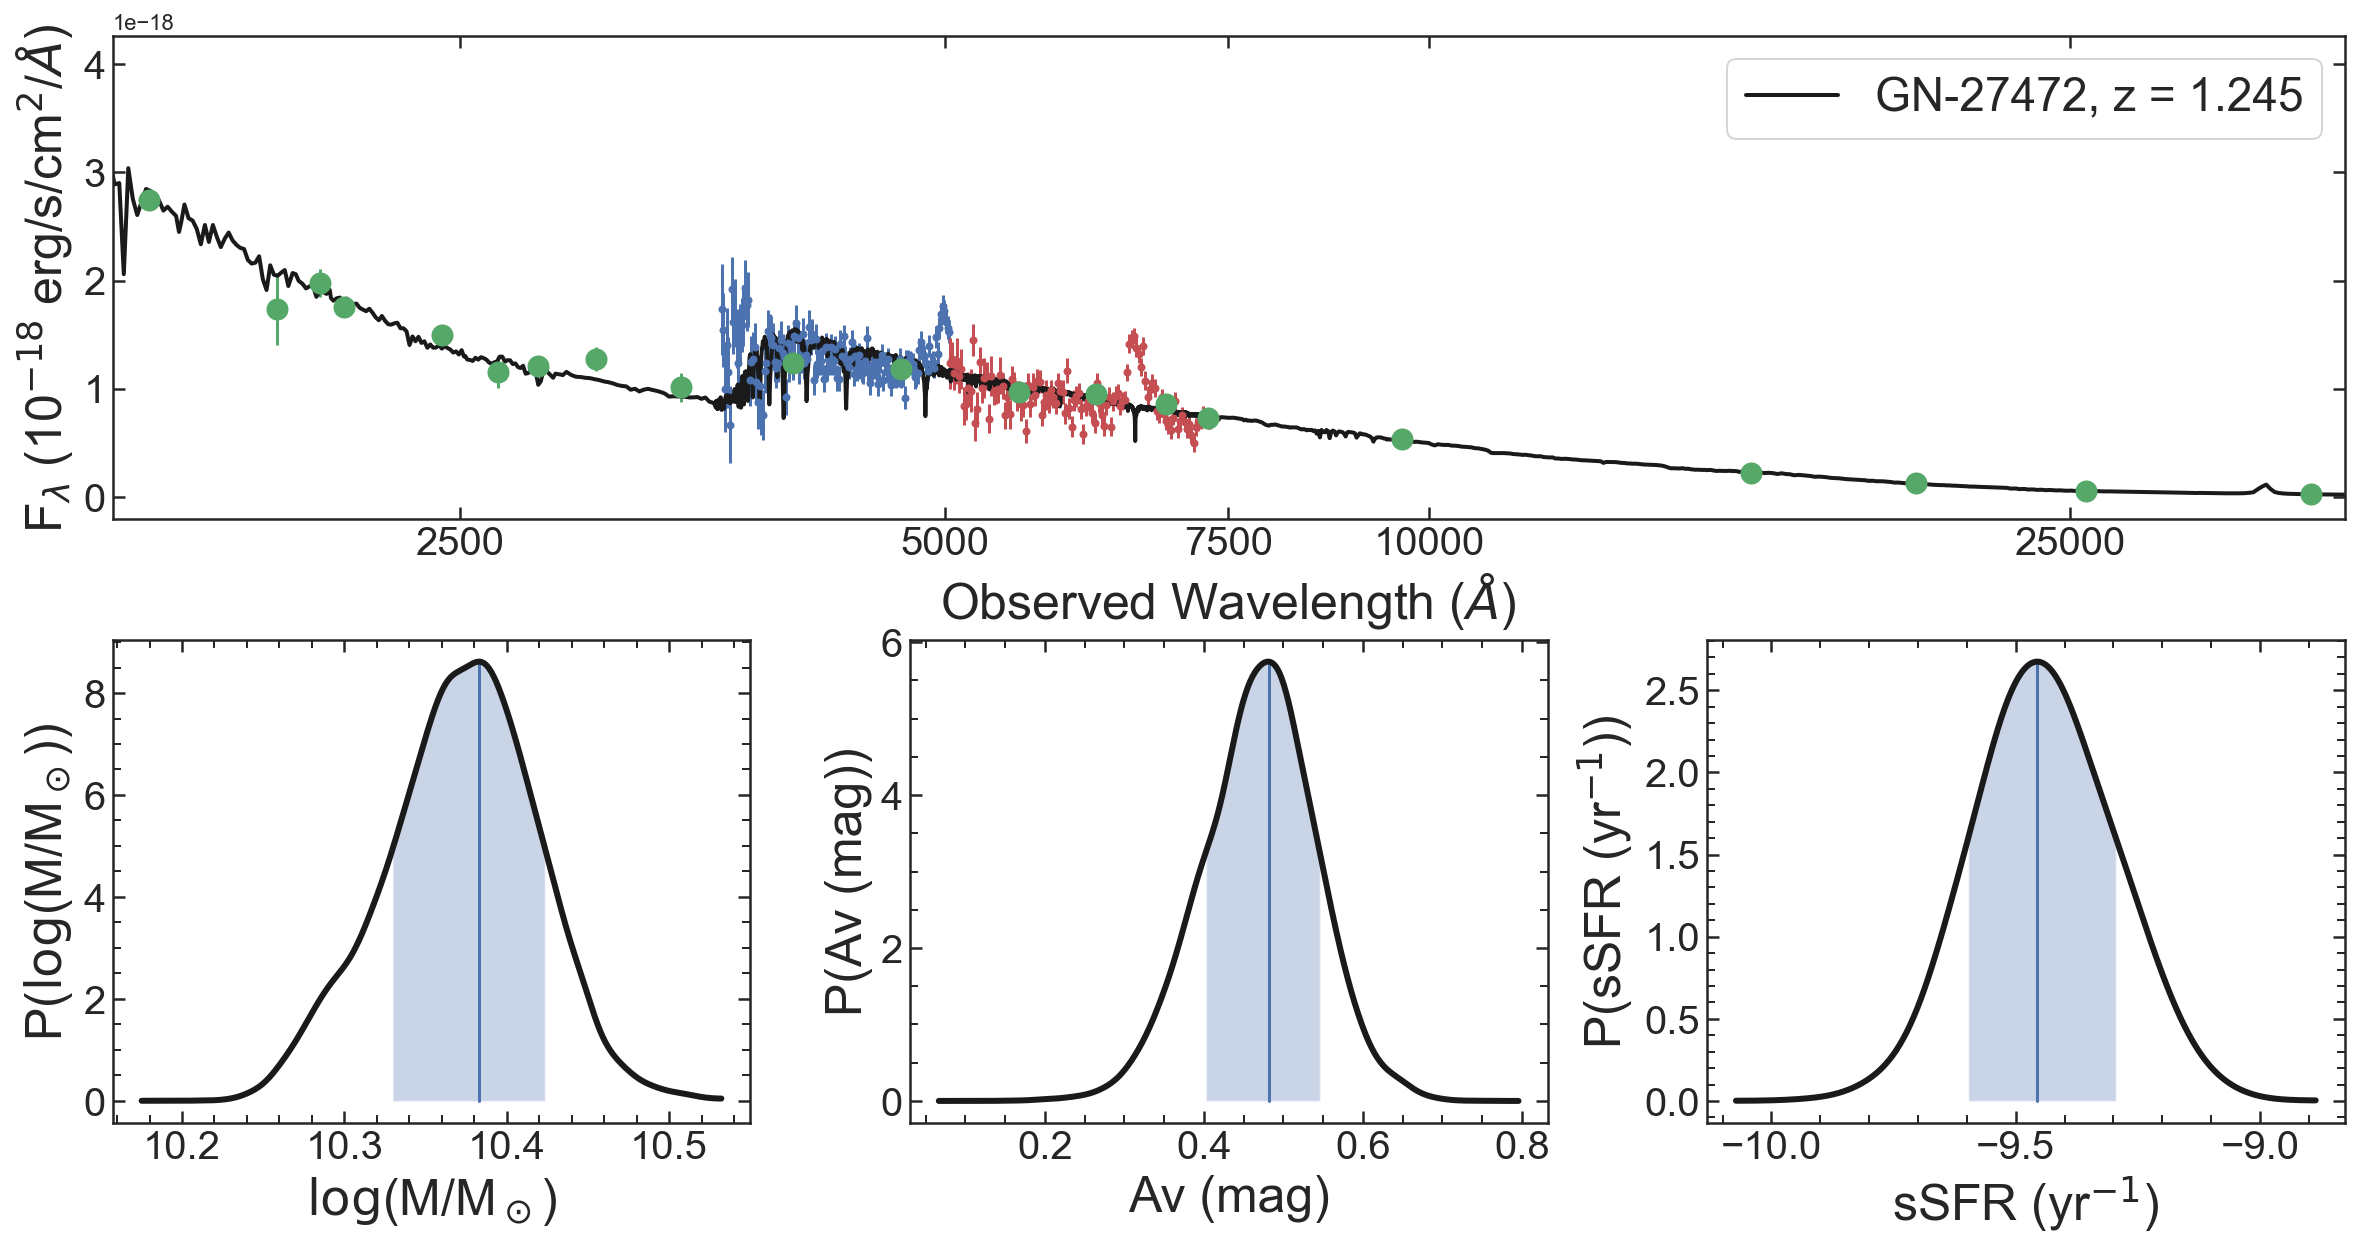

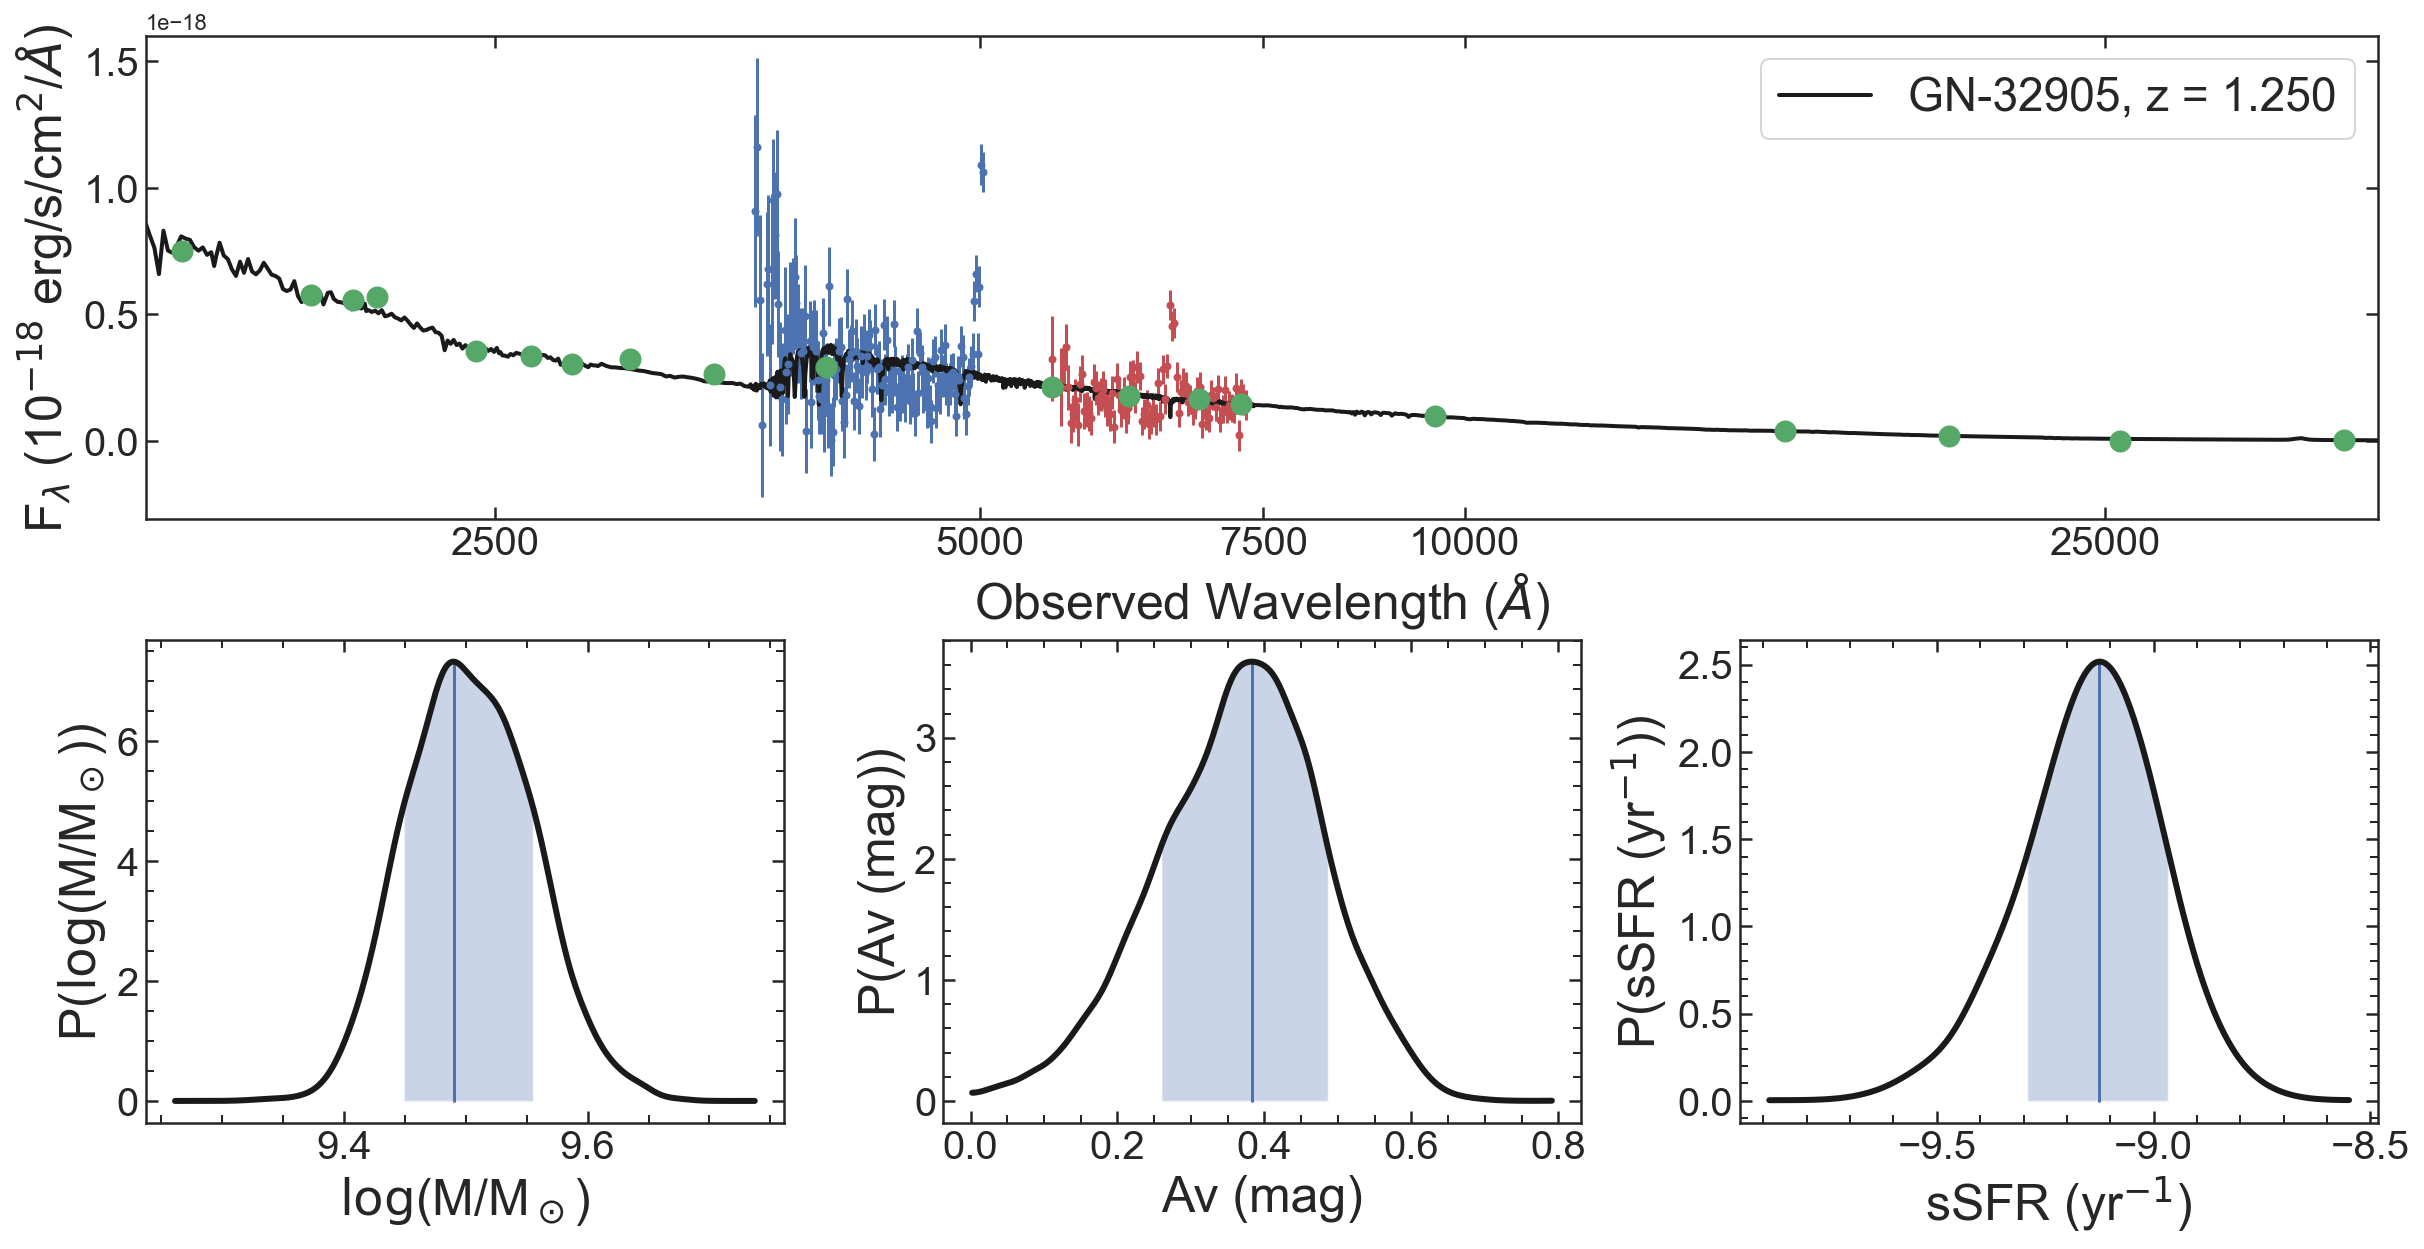

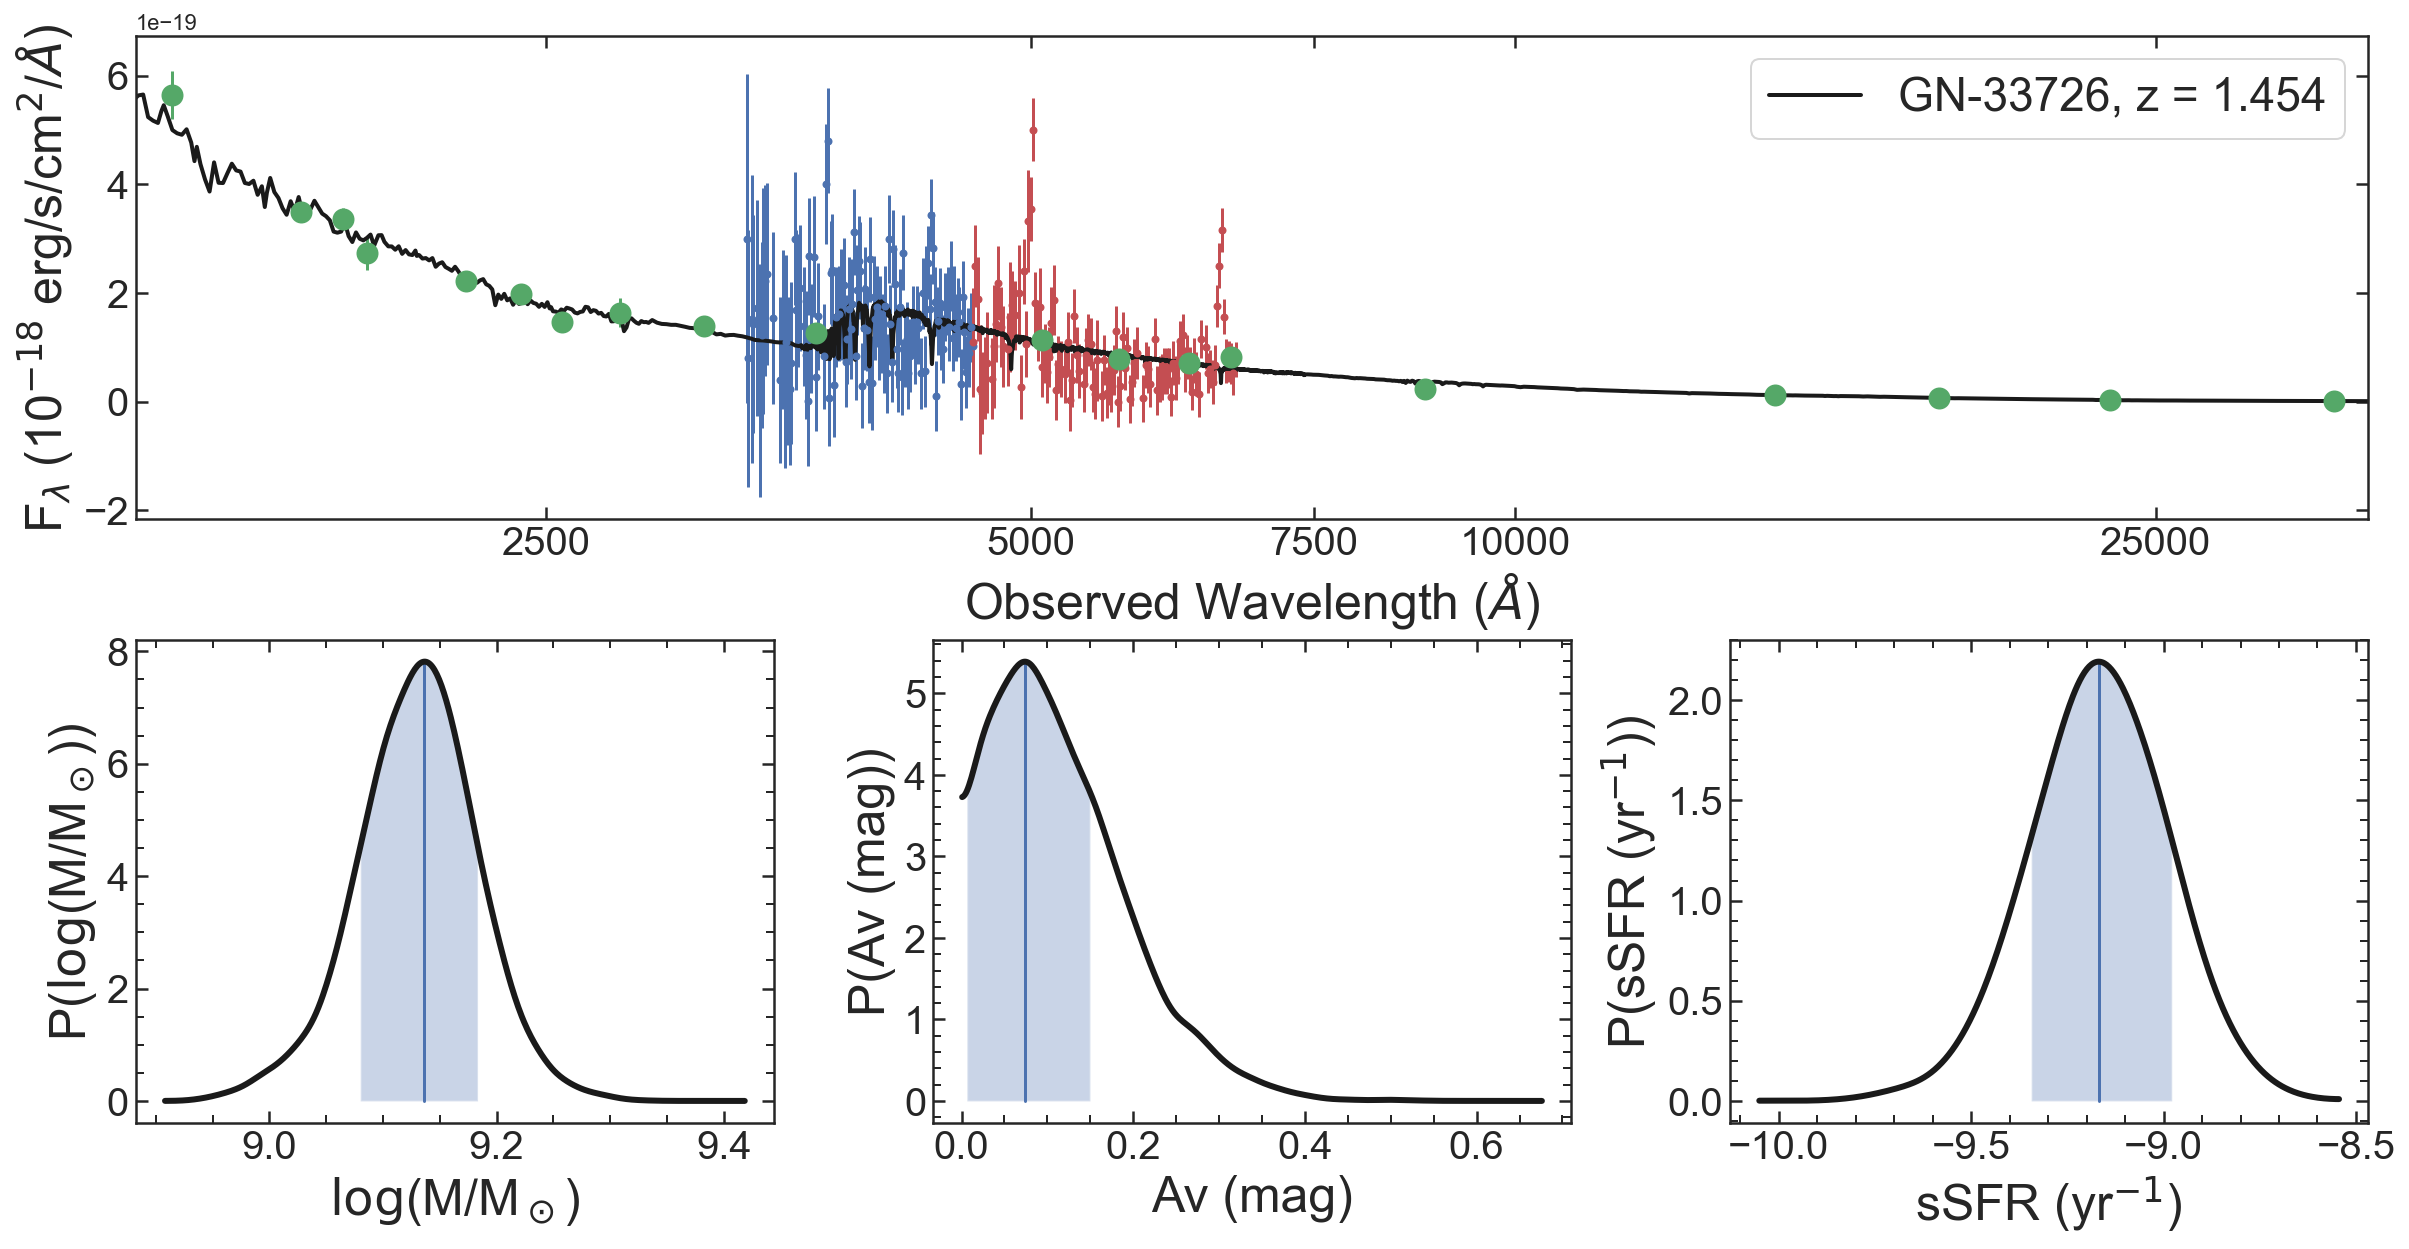

In [139]:
for i in range(len(field)):
    fld = field[i]
    gal = gid[i]
    sp = np.load('../full_specs/{}_{}_fullspec.npy'.format(fld, gal), allow_pickle=True).item()
    dfit = np.load('../data/posteriors/{}_{}_SFfit_p1_fits.npy'.format(fld, gal), allow_pickle = True).item()
    rshift = adb.query('field == "{}" and id == {}'.format(fld, gal)).zgrism.values[0]
    gs = gridspec.GridSpec(2,3, wspace = 0.25, hspace = 0.25)
    plt.figure(figsize = [20,10])
    ax1 = plt.subplot(gs[0,:])
    ax2 = plt.subplot(gs[1,0])
    ax3 = plt.subplot(gs[1,1])
    ax4 = plt.subplot(gs[1,2])

    if len(sp['Bwv']) > 0:
        IDX = [U for U in range(len(sp['Bwv'])) if 8150 < sp['Bwv'][U] < 15000]
        ax1.errorbar(sp['Bwv'][IDX]/(1+rshift), sp['Bfl'][IDX], sp['Ber'][IDX], fmt = 'bo' ,markersize=3)

    if len(sp['Rwv']) > 0:
        ax1.errorbar(sp['Rwv']/(1+rshift), sp['Rfl'], sp['Rer'], fmt = 'ro' ,markersize=3)

    ax1.errorbar(sp['Pwv']/(1+rshift), sp['Pfl'], sp['Per'], fmt = 'go', markersize = 10)

    ax1.plot(sp['wave'], sp['flam'],
            'k', linewidth = 2, label = '{}{}-{}, z = {:1.3f}'.format(fld[0], fld[1], gal, rshift))
    ax1.set_xlim(0.95 * min(sp['Pwv']/(1+rshift)), 1.05 * max(sp['Pwv']/(1+rshift)))
    ax1.legend(fontsize = 23)
    ax1.set_xlabel(r'Observed Wavelength ($\AA$)',size=25)
    ax1.set_ylabel(r'F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=25)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.set_xscale('log')
    ax1.set_xticks([2500, 5000, 7500, 10000, 25000])
    ax1.set_xticklabels([2500, 5000, 7500, 10000, 25000])
    ax1.minorticks_off()

    # lmass plot
    m,hdr, mod = Highest_density_region(dfit['Plm'], dfit['lm'])
    iPx = interp1d(dfit['lm'], dfit['Plm'])
    ax2.plot([m,m], [0, iPx(m)])
    ax2.fill_between(np.linspace(hdr[0], hdr[1]), iPx(np.linspace(hdr[0], hdr[1])), alpha = 0.3)
    ax2.plot(dfit['lm'], dfit['Plm'], 'k', linewidth = 3)
    ax2.set_xlabel(r'$\log$(M/M$_\odot$)',size=25)
    ax2.set_ylabel(r'P($\log$(M/M$_\odot$))',size=25)
    ax2.tick_params(axis='both', which='major', labelsize=20)


    # dust plot
    m,hdr, mod = Highest_density_region(dfit['Pd'], dfit['d'])
    iPx = interp1d(dfit['d'], dfit['Pd'])
    ax3.plot([m,m], [0, iPx(m)])
    ax3.fill_between(np.linspace(hdr[0], hdr[1]), iPx(np.linspace(hdr[0], hdr[1])), alpha = 0.3)
    ax3.plot(dfit['d'], dfit['Pd'], 'k', linewidth = 3)
    ax3.set_xlabel(r'Av (mag)',size=25)
    ax3.set_ylabel(r'P(Av (mag))',size=25)
    ax3.tick_params(axis='both', which='major', labelsize=20)

    # ssfr plot
    m,hdr, mod = Highest_density_region(dfit['Pssfr'], dfit['ssfr'])
    iPx = interp1d(dfit['ssfr'], dfit['Pssfr'])
    ax4.plot([m,m], [0, iPx(m)])
    ax4.fill_between(np.linspace(hdr[0], hdr[1]), iPx(np.linspace(hdr[0], hdr[1])), alpha = 0.3)
    ax4.plot(dfit['ssfr'], dfit['Pssfr'], 'k', linewidth = 3)
    ax4.set_xlabel(r'sSFR (yr$^{-1}$)',size=25)
    ax4.set_ylabel(r'P(sSFR (yr$^{-1}$))',size=25)
    ax4.tick_params(axis='both', which='major', labelsize=20)
    plt.savefig('../plots/starforming_gals/{}{}-{}.png'.format(fld[0], fld[1], gal), bbox_inches = 'tight')    

In [98]:
fld[1]

'N'

In [76]:
adb.query('field == "{}" and id == {}'.format(fld, gal)).zgrism.values[0]

1.507867356695205

# bulge dominated

In [16]:
Bdb = pd.read_pickle('../dataframes/galaxy_frames/goods_bulge_stellar_params.pkl')

In [17]:
len(Bdb)

56

In [5]:
Bdb.query('0.7 < zgrism < 1.5 and z_50 > 4 ')

,field,id,candels_id,lwa,lwa_hci,lwa_modality,Av,Av_hci,Av_modality,Z,...,zgrism,z_50,z_50_hci,z_50_modality,t_50,t_50_hci,t_50_modality,log_ssfr,log_ssfr_hci,log_ssfr_modality
10,GND,20432,14763,2.555352,"[2.354219840189475, 2.7503890184162154]",[1.2996038902190994],0.192891,"[0.14370017474255065, 0.3188209737772886]",[0.18832391701072032],1.392881,...,1.149262,4.751294,"[3.677279148206442, 6.238332296225172]",[0.0],4.053015,"[3.6006541196760065, 4.417425339067336]",[0.0],-11.889634,"[-12.169207505344694, -11.604579370141309]",[0.0]
13,GND,22246,16579,3.573312,"[3.2914514382163325, 3.75016609607204]",[0.26684715741272913],0.001428,"[0.0014278313927940918, 0.015083719903173266]",[0.0],1.106100,...,0.941617,5.302487,"[4.1979939821275485, 7.142385073895957]",[0.0],5.017537,"[4.653276164286758, 5.365254014629976]",[0.0],-12.165323,"[-12.420034582934434, -11.910610515426004]",[0.0]
25,GND,27951,21095,4.940358,"[4.732450920080542, 5.415575442250278]",[0.07375609572433385],0.085800,"[0.06290891669909002, 0.13278725946855774]","[0.17180291266775916, 0.1537909240725244]",1.019289,...,0.943186,8.156411,"[6.7427524023957055, 9.750890911660019]",[0.0],5.478445,"[5.30022135841595, 5.611871354705777]",[0.0],-11.982123,"[-12.21839119569529, -11.774785910849523]",[0.0]
50,GSD,39170,22002,4.123742,"[3.7733676057440926, 4.342726348186066]",[0.0],0.021168,"[0.010001116771156279, 0.046293949022772216]",[0.0],1.417148,...,1.018142,6.485127,"[5.05641356399682, 8.084056390493522]",[0.0],4.947784,"[4.633018624404068, 5.160250636010958]",[0.0],-12.794103,"[-13.130702627568773, -12.530434132269257]",[0.0]
52,GSD,39631,21772,3.669748,"[3.382866481421825, 3.8687144505213644]",[0.17607033966418403],0.249305,"[0.21795210285217748, 0.36359201614875625]","[0.06258381042844295, 0.035368630477673975, 0....",0.406727,...,1.028802,4.253510,"[3.1257364765527544, 4.9934109492374255]",[0.0],4.316501,"[3.6957251244832268, 4.5725909770357]",[0.0],-13.261453,"[-13.637640328173529, -12.314266506142502]",[0.0]
54,GSD,39805,21913,3.199281,"[2.8931781137725583, 3.658436291926796]",[0.0],0.075306,"[0.03352871851680251, 0.17614723783905023]",[0.0],1.283966,...,1.156102,5.385437,"[3.9710371367462836, 6.112846661156529]",[0.0],4.210654,"[3.7249601018051766, 4.370274428877609]",[0.0],-12.025575,"[-12.402775145010722, -11.716395018037446]",[0.0]
58,GSD,40623,22303,3.636022,"[3.44745183977623, 3.8188777799019533]",[0.0],0.051785,"[0.007101028615687193, 0.0828686692914147]",[0.0],1.349035,...,1.414259,9.395577,"[7.614003763238736, 10.627368182408823]",[0.0],3.983232,"[3.8153592260816405, 4.062937173905349]",[0.0],-11.882756,"[-12.07167791383442, -11.672843657347004]",[0.0]
77,GND,12739,9022,1.871431,"[1.6147617386097246, 2.701831105503831]",[0.0],0.002000,"[0.0019998971651701367, 0.07318604746443928]",[0.9748732067441481],0.651857,...,1.205851,4.089011,"[2.954139688315975, 5.409450133079175]",[0.0],3.611665,"[2.9269322003875478, 4.049843294228264]",[0.0],-11.580170,"[-12.14395045051018, -11.16208566964598]",[0.0]
103,GND,23435,16950,3.017657,"[2.599830898750084, 3.3548508375296766]",[0.0],0.001872,"[0.0018715235338835246, 0.059325183553914904]",[0.0],0.977945,...,1.141565,4.715754,"[3.4666207234198376, 6.200496960900142]",[0.0],4.068133,"[3.5063829431200126, 4.4372033530550326]",[0.0],-11.767812,"[-12.065033804639684, -11.464646215991593]",[0.0]
118,GND,35835,25505,3.849416,"[3.173674866952842, 4.231010217903579]",[0.0],0.002007,"[0.0020073329460341756, 0.05033693811218445]",[0.0],0.781314,...,1.119178,5.064330,"[3.667598194136727, 5.839963841494411]",[0.0],4.254221,"[3.7012358195603987, 4.444793618010726]",[0.0],-12.067100,"[-12.616638595544629, -11.664105265333216]",[0.0]


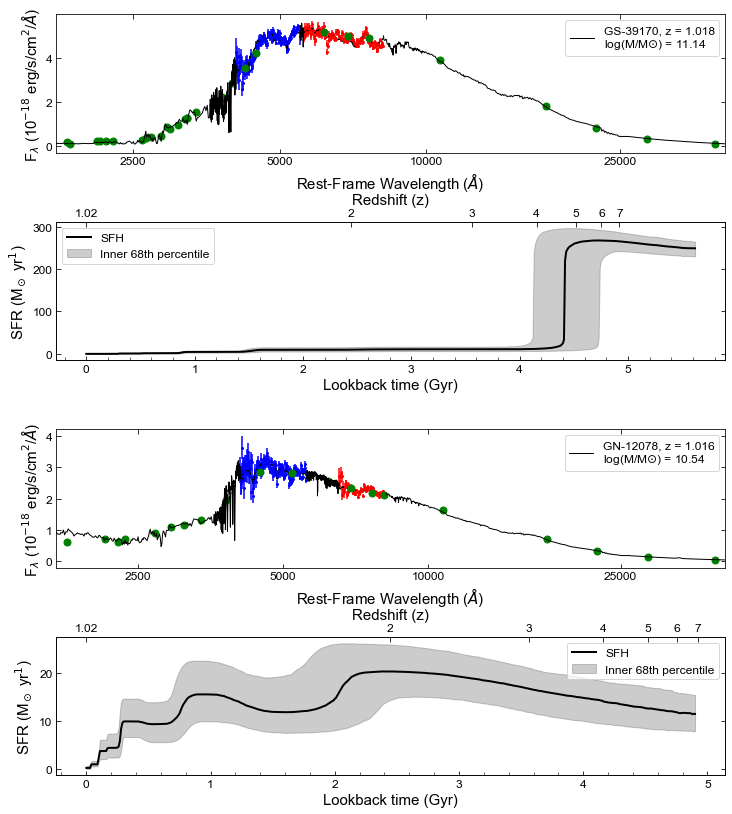

In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from matplotlib import gridspec
import matplotlib.pyplot as plt

### load in catalog to pull in values, NEED TO CHANGE TO YOUR PATH
adb = pd.read_pickle('../dataframes/fitdb/evolution_db_v2.pkl')

### set up grid for figure and figure size
gs = gridspec.GridSpec(4,1, hspace = 0.5)
plt.figure(figsize = [12,14])

### IDs of the galaxies used
gids = [39170,12078]

for i in range(len(gids)):
    ax1 = plt.subplot(gs[i*2])
    
    ### pull in values for each galaxy
    fld = adb.query('id == {}'.format(gids[i])).field.values[0]       #Field
    gal = adb.query('id == {}'.format(gids[i])).id.values[0]          #ID
    lssfr = adb.query('id == {}'.format(gids[i])).log_ssfr.values[0]  #log(sSFR)
    mass = adb.query('id == {}'.format(gids[i])).lmass.values[0]      #log(mass)
    sfr = 10**lssfr * 10**mass                                        #SFR 
    cmass = mass - 0.26                                               #mass with correcting factor
    lssfr = np.log10(sfr / 10**cmass)                                 #adjusted log(sSFR)
    rshift = adb.query('field == "{}" and id == {}'.format(fld, gal)).zgrism.values[0]     #redshift

    
    #####load in fullspectrum, NEED TO CHANGE TO YOUR PATH
    sp = np.load('../full_specs/{}_{}_fullspec.npy'.format(fld, gal), allow_pickle=True).item() 
    
    ### plot grism spectra
    if len(sp['Bwv']) > 0:
        IDX = [U for U in range(len(sp['Bwv'])) if 8200 < sp['Bwv'][U] < 15000]
        ax1.errorbar(sp['Bwv'][IDX]/(1+rshift), sp['Bfl'][IDX]*1E18, sp['Ber'][IDX]*1E18, fmt = 'bo' ,markersize=2)
        ax1.plot(sp['Bwv'][IDX]/(1+rshift), sp['Bmfl'][IDX]*1E18, 'k')

    if len(sp['Rwv']) > 0:
        ax1.errorbar(sp['Rwv']/(1+rshift), sp['Rfl']*1E18, sp['Rer']*1E18, fmt = 'ro' ,markersize=2)
        ax1.plot(sp['Rwv']/(1+rshift), sp['Rmfl']*1E18, 'k')

    ### plot photometry
    ax1.errorbar(sp['Pwv']/(1+rshift), sp['Pfl']*1E18, sp['Per']*1E18, fmt = 'go', markersize = 7)
    
    ### plot model spec
    IDB = [U for U in range(len(sp['wave'])) if sp['wave'][U] < (sp['Bwv'][IDX]/(1+rshift))[0]]
    ax1.plot(sp['wave'][IDB], sp['flam'][IDB]*1E18,
            'k', linewidth = 1,zorder = 10,
             label = '{}{}-{}, z = {:1.3f}\nlog(M/M$\odot$) = {:1.2f}'.format(fld[0], fld[1], gal, rshift, cmass))
    
    IDR = [U for U in range(len(sp['wave'])) if sp['wave'][U] > (sp['Rwv']/(1+rshift))[-1]]
    ax1.plot(sp['wave'][IDR], sp['flam'][IDR]*1E18,'k', linewidth = 1,zorder = 10)
    
    IDG = [U for U in range(len(sp['wave'])) if (sp['Bwv'][IDX]/(1+rshift))[-1] < sp['wave'][U] < (sp['Rwv']/(1+rshift))[0]]
    ax1.plot(sp['wave'][IDG], sp['flam'][IDG]*1E18,'k', linewidth = 1,zorder = 10)
    
    ### plot adjustments
    ax1.set_xlim(0.95 * min(sp['Pwv']/(1+rshift)), 1.05 * max(sp['Pwv']/(1+rshift)))
    ax1.legend(fontsize = 12)
    ax1.set_xlabel(r'Rest-Frame Wavelength ($\AA$)',size=15)
    ax1.set_ylabel(r'F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\AA$)',size=15)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.set_xscale('log')
    ax1.set_xticks([2500, 5000, 10000, 25000])
    ax1.set_xticklabels([2500, 5000, 10000, 25000])
    ax1.minorticks_off()
    
    ax2 = plt.subplot(gs[i*2 +1])
    
    ### load in SFH, NEED TO CHANGE TO YOUR PATH
    lbt, sfh = np.load('../data/B_sfh/{}_{}.npy'.format(fld, gal))
    lbt, sfh16 = np.load('../data/B_sfh/{}_{}_16.npy'.format(fld, gal))
    lbt, sfh84 = np.load('../data/B_sfh/{}_{}_84.npy'.format(fld, gal))
        
    ### plot SFH w/ errors
    ax2.plot(lbt, sfh, 'k', linewidth = 2, label = 'SFH')
    ax2.fill_between(lbt, sfh16, sfh84, alpha = 0.2, color = 'k', label = 'Inner 68th percentile')
    
    ### plot adjustments
    ax2.legend(fontsize = 12)
    ax2.set_xlabel('Lookback time (Gyr)',size=15)
    ax2.set_ylabel('SFR (M$_\odot$ yr$^1$)',size=15)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    
    ### setup to add redshift on top of SFH plots
    ax3 = ax2.twiny()
      
    ### get redshift locations for ticks
    zarray = [np.round(rshift,2)]
    
    idx = 0
    while cosmo.lookback_time(np.array(zarray[idx])).value  < 12.7:
        zarray.append(int(zarray[idx])+1)
        idx += 1 

    tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

    ### plot adjustments
    ax3.set_xlim(ax2.get_xlim())
    ax3.set_xticks(tarray)
    ax3.set_xticklabels(zarray)
    ax3.xaxis.set_ticks_position('top')
    ax3.set_xlabel('Redshift (z)', fontsize=15) 
    ax3.tick_params(axis='both', which='major', labelsize=12)
    ax3.minorticks_off()
    
#     plt.savefig('../plots/buldge_spec/spec_examples.pdf', bbox_inches = 'tight')        

In [166]:
cosmo.lookback_time(8)

<Quantity 12.83762055 Gyr>

In [5]:
from make_sfh_tool import Gen_sim_SFH

sfh_path = '../data/B_SFH/'
pos_path = '../data/posteriors/'

for i in adb.index:
    if not os.path.isfile('../data/B_sfh/{}_{}_16.npy'.format(adb.field[i], adb.id[i])):
        try:
            fname = '{}_{}_tabfit.npy'.format(adb.field[i], adb.id[i])

            sfh = Gen_sim_SFH(fname, 5000, adb.zgrism[i])

            with open(sfh_path + '{}_{}_1D.pkl'.format(adb.field[i], adb.id[i]), 'wb') as output:
                pickle.dump(sfh, output, pickle.HIGHEST_PROTOCOL)

        except:
            fname ='{}_{}_SFfit_p1.npy'.format(adb.field[i], adb.id[i])

            sfh = Gen_sim_SFH(fname, 5000, adb.zgrism[i])

            with open(sfh_path + '{}_{}_p1_1D.pkl'.format(adb.field[i], adb.id[i]), 'wb') as output:
                pickle.dump(sfh, output, pickle.HIGHEST_PROTOCOL)

        np.save(sfh_path + '{}_{}'.format(adb.field[i], adb.id[i]),[sfh.LBT, sfh.SFH],allow_pickle=True)
        np.save(sfh_path + '{}_{}_16'.format(adb.field[i], adb.id[i]),[sfh.LBT, sfh.SFH_16],allow_pickle=True)
        np.save(sfh_path + '{}_{}_84'.format(adb.field[i], adb.id[i]),[sfh.LBT, sfh.SFH_84],allow_pickle=True)





In [6]:
for i in adb.index:
    if not os.path.isfile('../data/B_sfh/{}_{}_16.npy'.format(adb.field[i], adb.id[i])):
        if not os.path.isfile(pos_path + '{}_{}_tabfit.npy'.format(adb.field[i], adb.id[i])):
            if len(glob(pos_path + '{}_{}_tabfit*'.format(adb.field[i], adb.id[i]))) > 0:

                fit_dict = {}
                params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm',
                          'z', 'd', 'bp1', 'rp1', 'ba', 'bb', 'bl', 'ra', 'rb', 'rl']
                P_params = ['Pm', 'Pa', 'Pm1', 'Pm2', 'Pm3', 'Pm4', 'Pm5', 'Pm6', 'Pm7', 'Pm8', 'Pm9', 'Pm10', 'Plm',
                          'Pz', 'Pd', 'Pbp1', 'Prp1', 'Pba', 'Pbb', 'Pbl', 'Pra', 'Prb', 'Prl']

                bf_params = ['bfm', 'bfa', 'bfm1', 'bfm2', 'bfm3', 'bfm4', 'bfm5', 'bfm6', 'bfm7', 'bfm8', 'bfm9', 'bfm10', 'bflm',
                          'bfz', 'bfd', 'bfbp1', 'bfrp1', 'bfba', 'bfbb', 'bfbl', 'bfra', 'bfrb', 'bfrl']

                for ii in range(len(params)):
                    t,pt = np.load( pos_path + '{}_{}_tabfit_{}.npy'.format(adb.field[i], adb.id[i], P_params[ii]) )
                    fit_dict[params[ii]] = t
                    fit_dict[P_params[ii]] = pt

                bfits = np.load('../data/bestfits/{}_{}_tabfit_bfit.npy'.format(adb.field[i], adb.id[i]))

                for x in range(len(bf_params)):
                    fit_dict[bf_params[x]] = bfits[x]

                np.save(pos_path + '{}_{}_tabfit'.format(adb.field[i], adb.id[i]),fit_dict)
                
                
        if not os.path.isfile(pos_path + '{}_{}_SFfit_p1_fits.npy'.format(adb.field[i], adb.id[i])):
            if len(glob(pos_path + '{}_{}_SFfit_p1*'.format(adb.field[i], adb.id[i]))) > 0:
                
                fit_dict = {}
                params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'lm', 'd', 'bp1', 'rp1', 'ba', 'bb', 'bl', 'ra', 'rb', 'rl']
                P_params = ['Pm', 'Pa', 'Pm1', 'Pm2', 'Pm3', 'Pm4', 'Pm5', 'Pm6', 'Plm', 'Pd', 
                            'Pbp1', 'Prp1', 'Pba', 'Pbb', 'Pbl', 'Pra', 'Prb', 'Prl']
                bf_params = ['bfm', 'bfa', 'bfm1', 'bfm2', 'bfm3', 'bfm4', 'bfm5', 'bfm6', 
                            'bflm', 'bfd', 'bfbp1', 'bfrp1', 'bfba', 'bfbb', 'bfbl', 'bfra', 'bfrb', 'bfrl']

                for ii in range(len(params)):
                    t,pt = np.load( pos_path + '{}_{}_SFfit_p1_{}.npy'.format(adb.field[i], adb.id[i], P_params[ii]) )
                    fit_dict[params[ii]] = t
                    fit_dict[P_params[ii]] = pt

                bfits = np.load('../data/bestfits/{}_{}_SFfit_p1_bfit.npy'.format(adb.field[i], adb.id[i]))

                for x in range(len(bf_params)):
                    fit_dict[bf_params[x]] = bfits[x]

                np.save(pos_path + '{}_{}_SFfit_p1'.format(adb.field[i], adb.id[i]),fit_dict)
                

GND_10960_SFfit_p1_fits.npy  GND_36161_tabfit.npy
GND_11067_SFfit_p1_fits.npy  GND_36290_SFfit_p1_fits.npy
GND_11327_SFfit_p1_fits.npy  GND_36348_tabfit.npy
GND_11339_SFfit_p1_fits.npy  GND_36530_tabfit.npy
GND_11592_SFfit_p1_fits.npy  GND_36808_SFfit_p1_fits.npy
GND_11630_SFfit_p1_fits.npy  GND_36838_tabfit.npy
GND_11932_SFfit_p1_fits.npy  GND_36933_SFfit_p1_fits.npy
GND_12025_SFfit_p1_fits.npy  GND_36943_tabfit.npy
GND_12078_tabfit.npy         GND_37006_SFfit_p1_fits.npy
GND_12141_SFfit_p1_fits.npy  GND_37064_SFfit_p1_fits.npy
GND_12451_tabfit.npy         GND_37085_SFfit_p1_fits.npy
GND_12472_SFfit_p1_fits.npy  GND_37180_tabfit.npy
GND_12478_tabfit.npy         GND_37186_tabfit.npy
GND_12677_SFfit_p1_fits.npy  GND_37188_SFfit_p1_fits.npy
GND_12739_tabfit.npy         GND_37189_tabfit.npy
GND_12793_tabfit.npy         GND_37210_tabfit.npy
GND_12849_SFfit_p1_fits.npy  GND_37233_SFfit_p1_fits.npy
GND_13117_SFfit_p1_fits.npy  GND_37282_SFfit_p1_fits.npy
GND_13182_tabfit.npy         GND_3730

In [48]:
ls ../data/bestfits

ALMA_26272_bfit.npy              GND_37210_delayfit_bfit.npy
ALMA_29257_bfit.npy              GND_37210_tabfit_bfit.npy
ALMA_38843_bfit.npy              GND_37210_zfit_bfit.npy
ALMA_39012_bfit.npy              GND_37232_delayfit_bfit.npy
ALMA_39364_bfit.npy              GND_37232_tabfit_bfit.npy
ALMA_40223_bfit.npy              GND_37232_zfit_bfit.npy
ALMA_41520_bfit.npy              GND_37281_tabfit_bfit.npy
ALMA_42113_bfit.npy              GND_37281_zfit_bfit.npy
ALMA_42778_bfit.npy              GND_37311_tabfit_bfit.npy
ALMA_43007_bfit.npy              GND_37325_tabfit_bfit.npy
ALMA_44042_bfit.npy              GND_37326_tabfit_bfit.npy
GND_10512_SFfit_p1_bfit.npy      GND_37326_zfit_bfit.npy
GND_10639_SFMfit_bfit.npy        GND_37340_delayfit_bfit.npy
GND_10639_SFfit_bfit.npy         GND_37340_tabfit_bfit.npy
GND_10639_SFfit_p1_bfit.npy      GND_37340_zfit_bfit.npy
GND_10639_SFfit_p2_bfit.npy      GND_37375_tabfit_bfit.npy
GND_10960_SFfit_p1_bfit.npy      GND_37395_SFfit_bfit.npy
GN